## Import Library : 분석에 사용할 모듈 설치 

In [1]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip
# !pip install xgboost --user --upgrade
# !pip install lightgbm --user --upgrade
# !pip install catboost --user --upgrade
# !pip install mlxtend --user --upgrade

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# modeling algorithms
# general
import statsmodels.api as sm 
from scipy import stats

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text, export_graphviz
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from xgboost import plot_importance as plot_importance_xgb
# from lightgbm import plor_importance as plot_importance_lgbm
from catboost import Pool, CatBoostClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.plotting import plot_decision_regions

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn import metrics

# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve



## 사용자 정의 함수

In [3]:
from module_classification import *

## Base Algorithm : Logistic Regression

In [4]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Titanic.csv')
df = pd.read_csv(location)

# 데이터 전처리
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(712, 11) (712, 1)
(179, 11) (179, 1)


Effect of x..


,features,coef,odds
0,const,2.62,13.70
1,PassengerId,0.17,1.18
2,Pclass,-1.61,0.20
3,Sex,-1.40,0.25
4,Age,-1.26,0.29
5,SibSp,-1.87,0.15
6,Parch,-0.88,0.42
7,Ticket,0.47,1.61
8,Fare,0.73,2.07
9,Cabin,-0.35,0.70


ROC Curve: Train


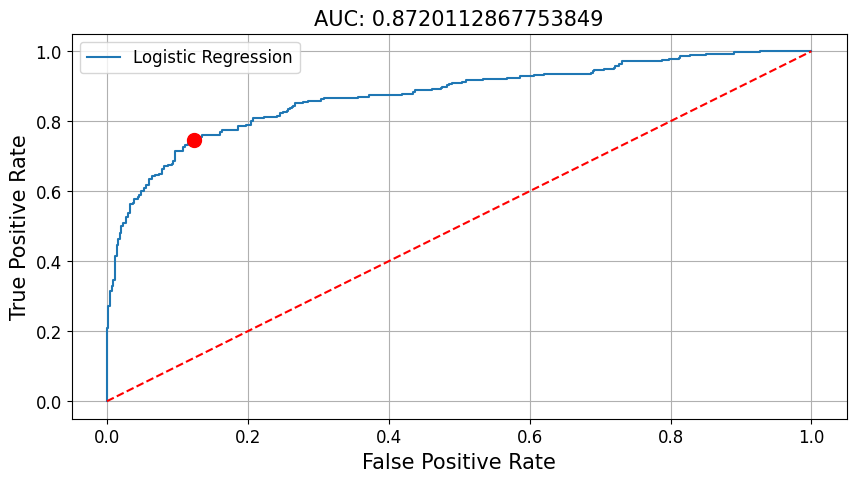

ROC Curve: Test


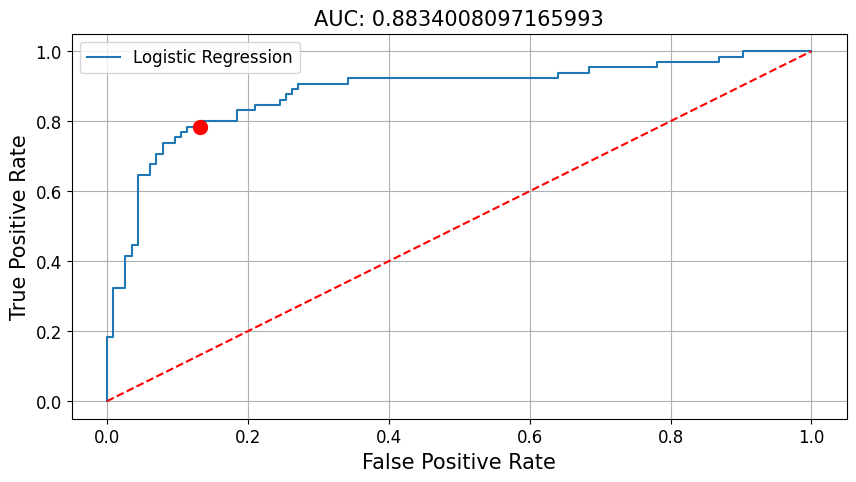

Precision-Recall Curve: Train


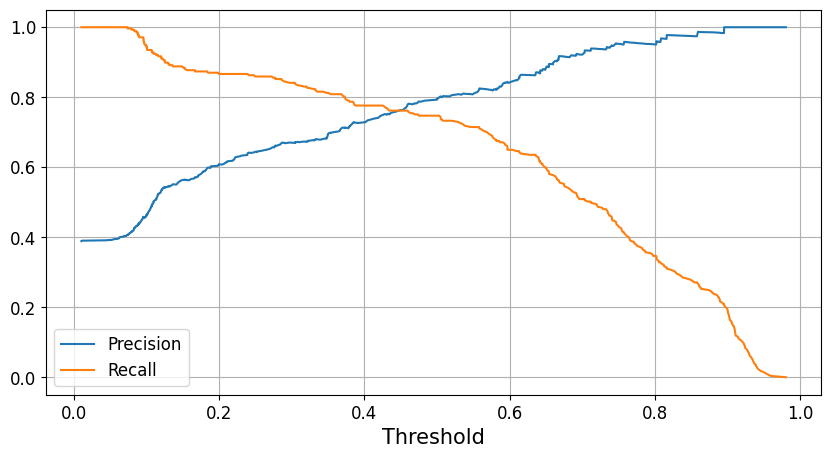

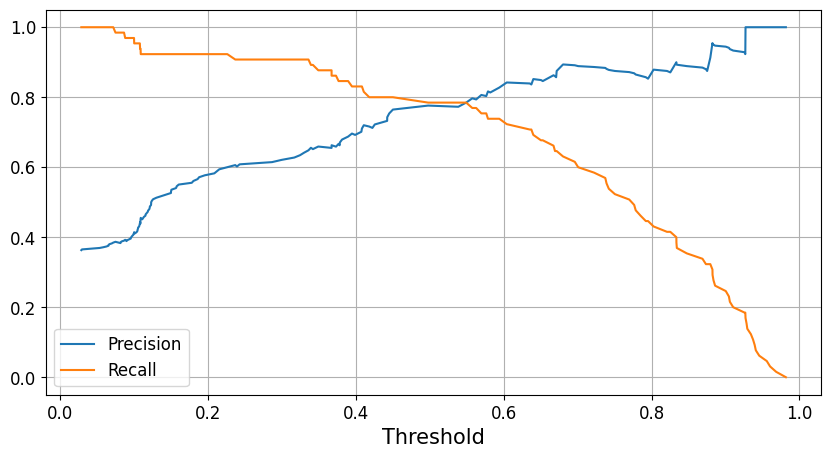

,Accuracy,AUC
Train,0.83,0.81
Test,0.84,0.83


In [5]:
# Logistic Regression
X_train_fes = sm.add_constant(X_train_fes)
X_test_fes = sm.add_constant(X_test_fes)

model_logitreg = LogisticRegression(fit_intercept=False)
model_logitreg.fit(X_train_fes, Y_train)

# 계수 해석
print('Effect of x..')
display(pd.DataFrame({'features': X_train_fes.columns,
                      'coef': model_logitreg.coef_[0],
                      'odds': np.exp(model_logitreg.coef_[0])}))

# 예측
Y_trpred = model_logitreg.predict(X_train_fes)
Y_tepred = model_logitreg.predict(X_test_fes)
P_trpred = model_logitreg.predict_proba(X_train_fes)
P_tepred = model_logitreg.predict_proba(X_test_fes)

# 평가/검증
## Confution Matrix
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:, 1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:, 1])

# Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:, 1])
evaluation_class_PrecisionRecall(Y_test, P_tepred[:, 1])

## 성능검증
Score_logitreg = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_logitreg

## Advanced Algorithm : Regularization

### Ridge

Effrct of x..


,features,coef,odds
0,const,1.05,2.87
1,PassengerId,0.27,1.31
2,Pclass,-0.88,0.42
3,Sex,-0.90,0.41
4,Age,-0.13,0.88
5,SibSp,-0.35,0.70
6,Parch,-0.10,0.91
7,Ticket,0.34,1.41
8,Fare,0.31,1.37
9,Cabin,-0.17,0.84


Confusion Matrix : Train
Confuction Matrix: Test
Classification Metrics : Train
              precision    recall  f1-score   support

     class 0       0.82      0.86      0.84       435
     class 1       0.77      0.70      0.73       277

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.79       712
weighted avg       0.80      0.80      0.80       712

classfication Metrics : Test
              precision    recall  f1-score   support

     class 0       0.88      0.83      0.86       114
     class 1       0.73      0.80      0.76        65

    accuracy                           0.82       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.82      0.82       179

ROC Curve Train


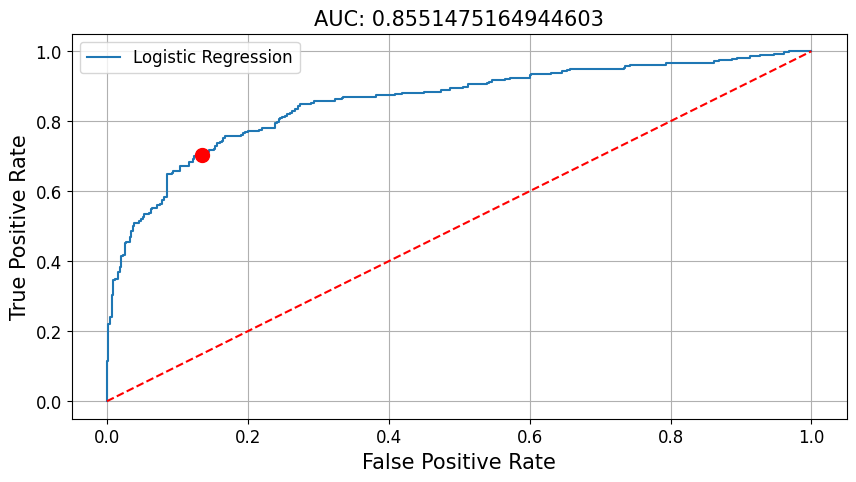

ROC Curve : Test


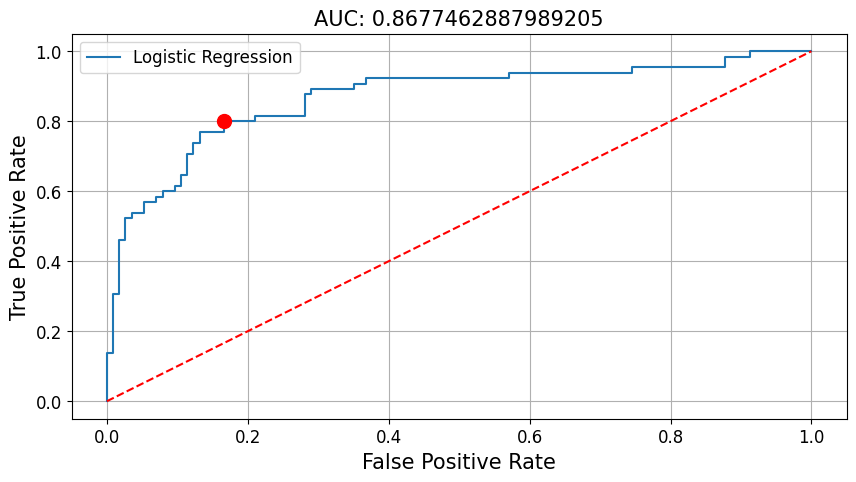

Precision-Recall Curve : Train


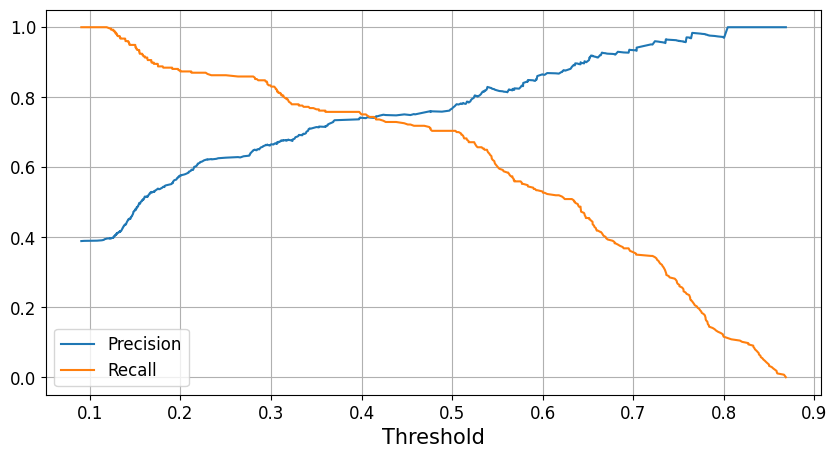

Precision-Recall Curve Test


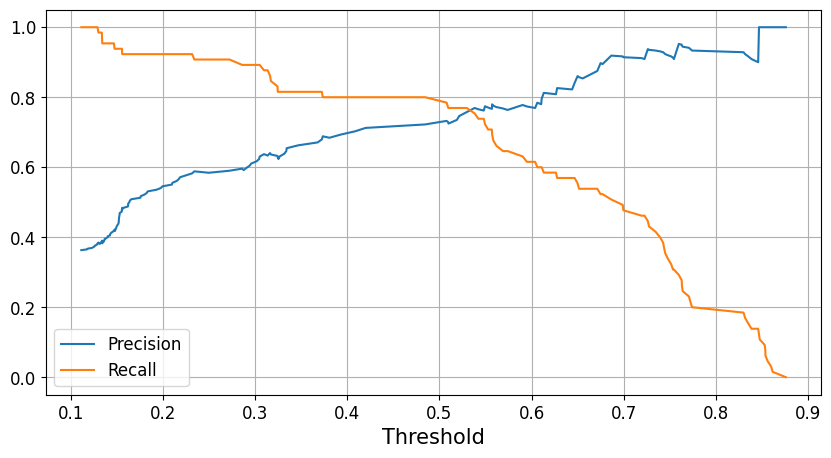

,Accuracy,AUC
Train,0.80,0.78
Test,0.82,0.82


In [7]:
# Logistic Regression : Ridge
model_ridge = LogisticRegression(fit_intercept=False,
                                 penalty='l2', C=0.1)
model_ridge.fit(X_train_fes, Y_train)

# 계수 해석
print('Effrct of x..')
display(pd.DataFrame({'features': X_test_fes.columns,
                      'coef': model_ridge.coef_[0],
                      'odds': np.exp(model_ridge.coef_[0])}))

# 예측
Y_trpred = model_ridge.predict(X_train_fes)
Y_tepred = model_ridge.predict(X_test_fes)
P_trpred = model_ridge.predict_proba(X_train_fes)
P_tepred = model_ridge.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix : Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confuction Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics : Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('classfication Metrics : Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:, 1])
print('ROC Curve : Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:, 1])

## Precision-Recall Curve
print('Precision-Recall Curve : Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:, 1])
print('Precision-Recall Curve Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:, 1])

## 성능검증
Score_ridge = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_ridge


### Lasso

Effect of X..


,features,coef,odds
0,const,1.26,3.51
1,PassengerId,0.00,1.00
2,Pclass,-0.97,0.38
3,Sex,-0.62,0.54
4,Age,0.00,1.00
5,SibSp,0.00,1.00
6,Parch,0.00,1.00
7,Ticket,0.00,1.00
8,Fare,0.00,1.00
9,Cabin,0.00,1.00


Confusion Martix: Train
confusion Matrix : Test
Classification Metrics : Train
              precision    recall  f1-score   support

     class 0       0.82      0.83      0.83       435
     class 1       0.73      0.71      0.72       277

    accuracy                           0.79       712
   macro avg       0.78      0.77      0.77       712
weighted avg       0.79      0.79      0.79       712

Classification Metrics : Test
              precision    recall  f1-score   support

     class 0       0.88      0.80      0.83       114
     class 1       0.69      0.80      0.74        65

    accuracy                           0.80       179
   macro avg       0.78      0.80      0.79       179
weighted avg       0.81      0.80      0.80       179

ROC Curve : Train


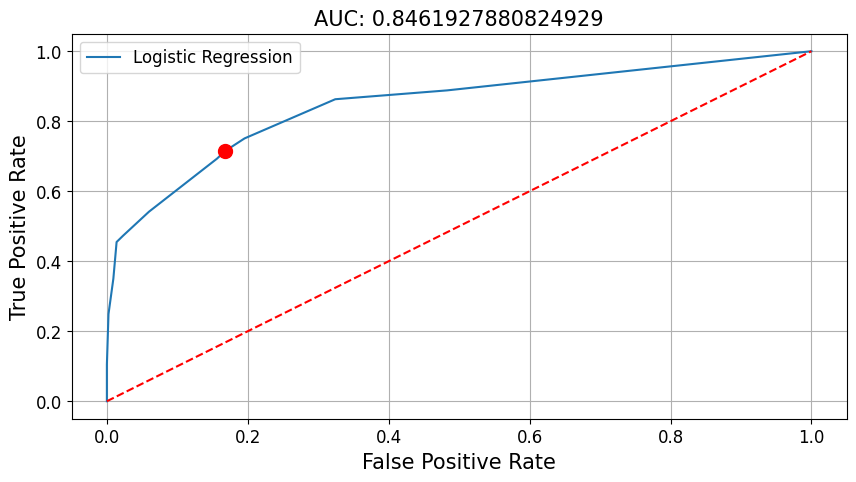

ROC Curve : Test


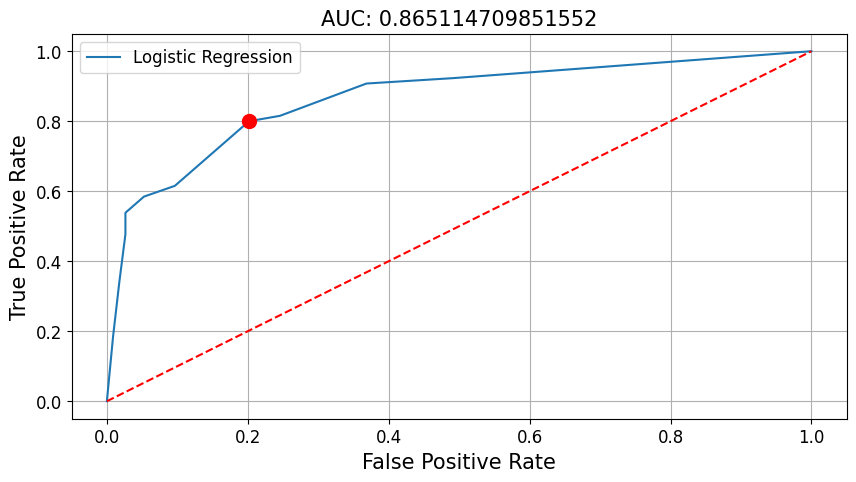

Precision-Recall Curve : Train


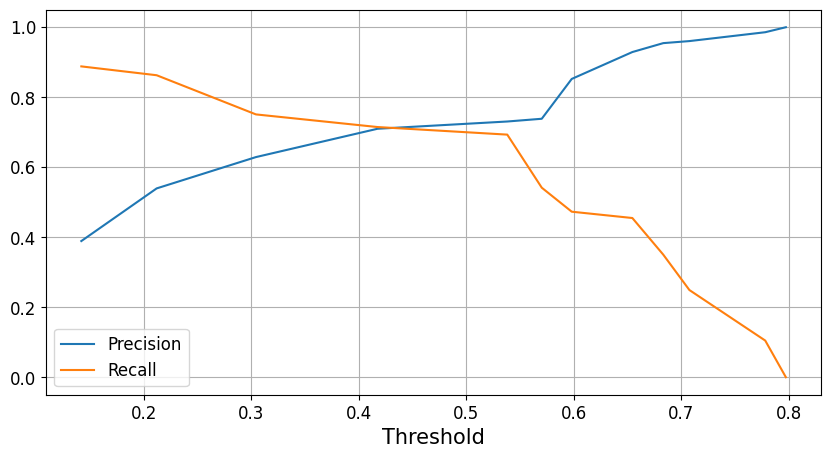

Precisiton-Recall Curve : Test


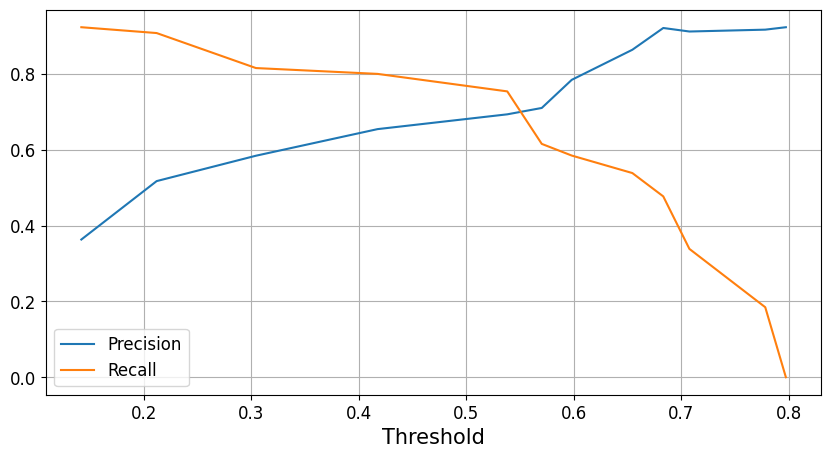

,Accuracy,AUC
Train,0.79,0.77
Test,0.80,0.80


In [11]:
# Logistic Regression : Lasso
model_lasso = LogisticRegression(fit_intercept=False, 
                                 penalty='l1', C=0.1, solver='saga')
model_lasso.fit(X_train_fes, Y_train)

# 계수 해석
print('Effect of X..')
display(pd.DataFrame({'features': X_train_fes.columns,
                      'coef': model_lasso.coef_[0],
                      'odds': np.exp(model_lasso.coef_[0])}))

# 예측
Y_trpred = model_lasso.predict(X_train_fes)
Y_tepred = model_lasso.predict(X_test_fes)
P_trpred = model_lasso.predict_proba(X_train_fes)
P_tepred = model_lasso.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Martix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('confusion Matrix : Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics : Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics : Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve : Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:, 1])
print('ROC Curve : Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:, 1])

# Precision-Recall Curve
print('Precision-Recall Curve : Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:, 1])
print('Precisiton-Recall Curve : Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:, 1])

## 성능검증
Score_lasso = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_lasso

### Elastic Net

Effect of X..


,features,coef,odds
0,const,1.62,5.06
1,PassengerId,0.08,1.09
2,Pclass,-1.26,0.28
3,Sex,-1.06,0.35
4,Age,-0.04,0.96
5,SibSp,-0.51,0.60
6,Parch,0.00,1.00
7,Ticket,0.09,1.09
8,Fare,0.00,1.00
9,Cabin,-0.07,0.94


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.82      0.86      0.84       435
     class 1       0.76      0.71      0.73       277

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.82      0.85       114
     class 1       0.72      0.80      0.76        65

    accuracy                           0.82       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.82      0.82      0.82       179

ROC Curve: Train


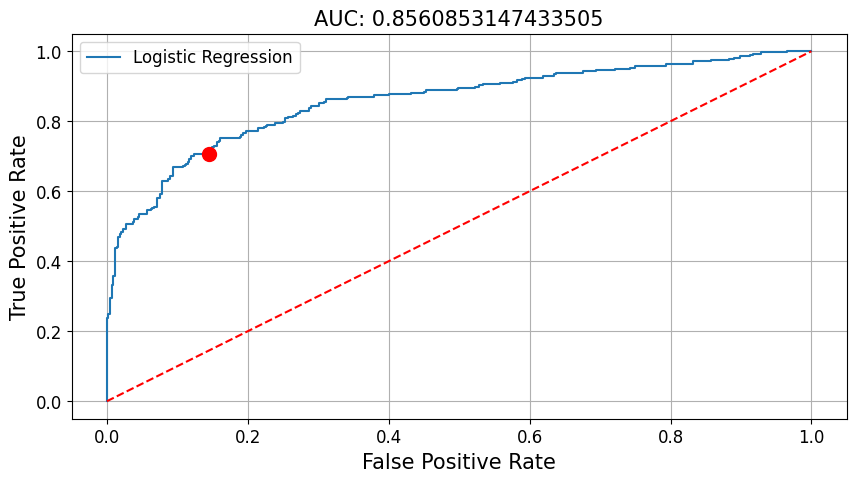

ROC Curve: Test


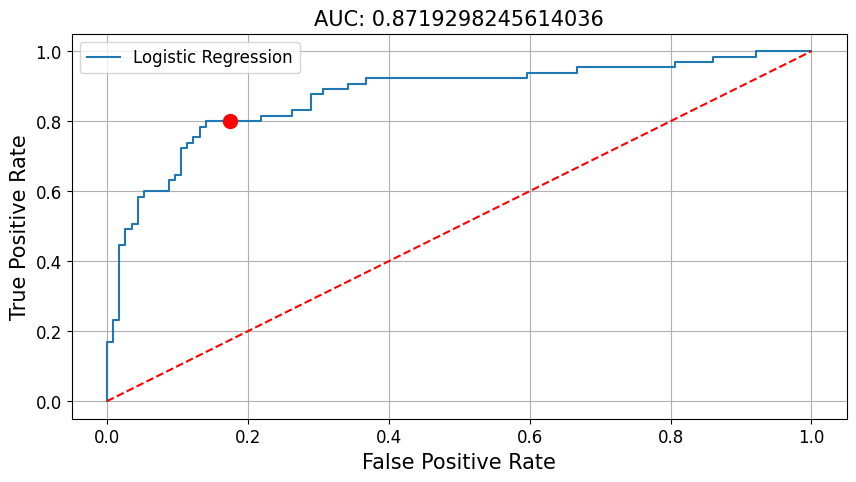

Precision-Recall Curve: Train


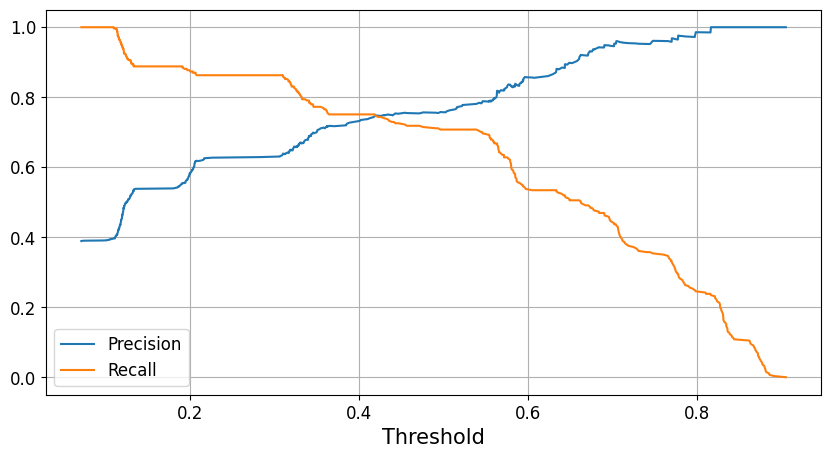

Precision-Recall Curve: Test


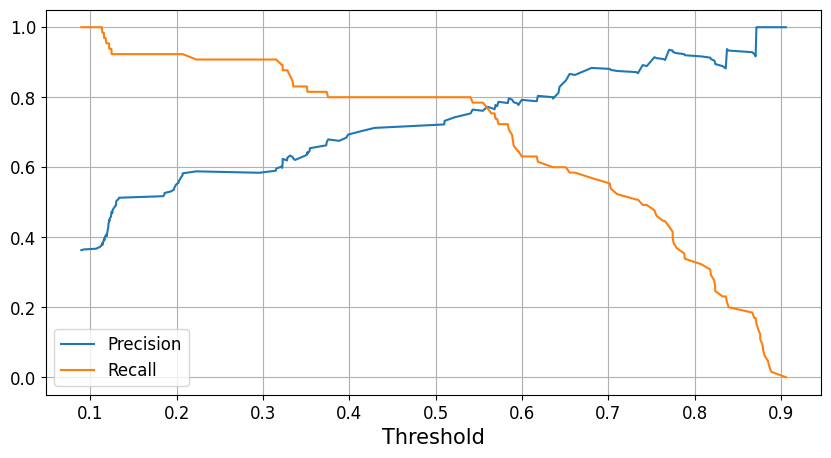

,Accuracy,AUC
Train,0.80,0.78
Test,0.82,0.81


In [12]:
# Logistic Regression : Elastic Net
model_en = LogisticRegression(fit_intercept=False,
                              penalty='elasticnet', C=0.2, l1_ratio=0.5, solver='saga')
model_en.fit(X_train_fes, Y_train)

## 계수 해석
print("Effect of X..")
display(pd.DataFrame({'features': X_train_fes.columns,
                      'coef': model_en.coef_[0],
                      'odds': np.exp(model_en.coef_[0])}))

# 예측
Y_trpred = model_en.predict(X_train_fes)
Y_tepred = model_en.predict(X_test_fes)
P_trpred = model_en.predict_proba(X_train_fes)
P_tepred = model_en.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_en = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_en

## Advanced Algorithm : Voting

In [13]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Titanic.csv')
df = pd.read_csv(location)

# 데이터 전처리
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(712, 11) (712, 1)
(179, 11) (179, 1)


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.85      0.92      0.88       435
     class 1       0.85      0.74      0.79       277

    accuracy                           0.85       712
   macro avg       0.85      0.83      0.84       712
weighted avg       0.85      0.85      0.85       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.86      0.87       114
     class 1       0.76      0.80      0.78        65

    accuracy                           0.84       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


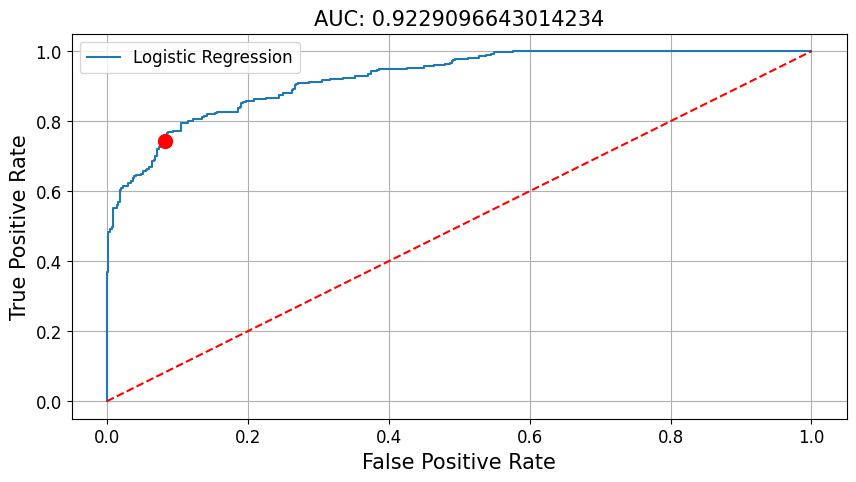

ROC Curve: Test


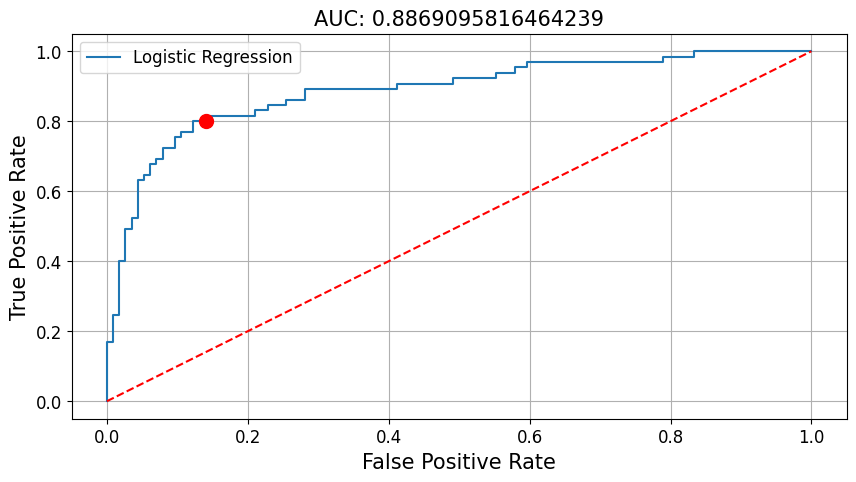

Precision-Recall Curve: Train


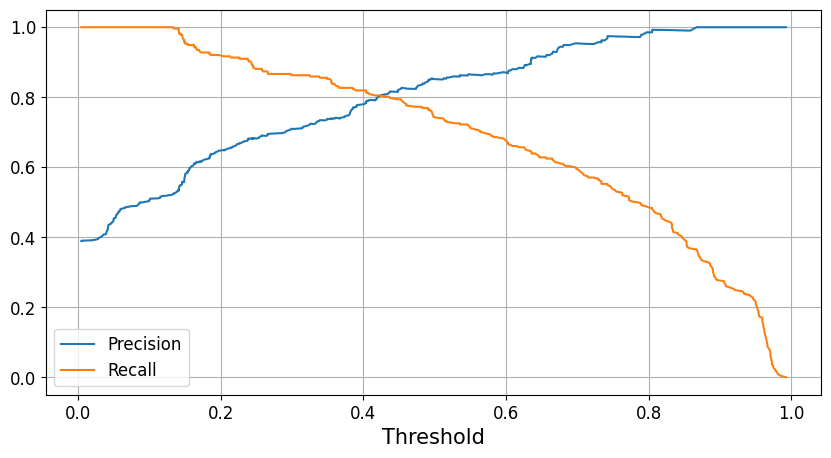

Precision-Recall Curve: Test


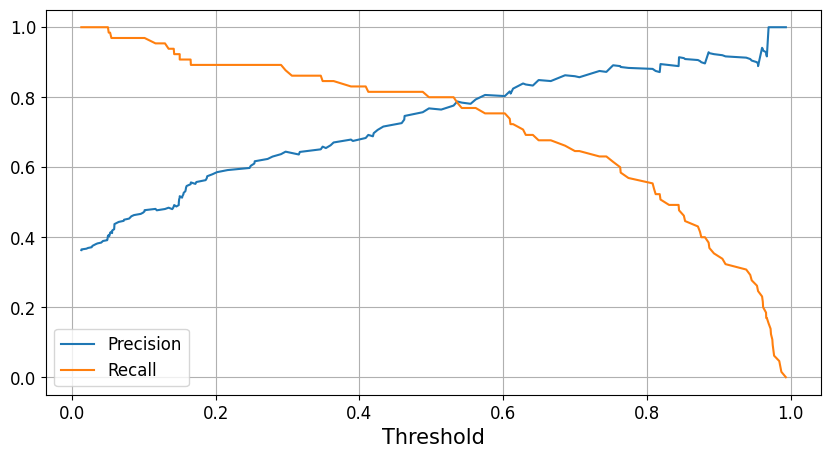

,Accuracy,AUC
Train,0.85,0.83
Test,0.84,0.83


In [14]:
# Voting
# Weak Learners
model_logitreg = LogisticRegression()
model_knn = KNeighborsClassifier()
clf = [('LR', model_logitreg), ('KNN', model_knn)]
voting_type = 'soft'
model_voting = VotingClassifier(estimators=clf, voting=voting_type)
model_voting.fit(X_train_fes, Y_train)

# 예측
Y_trpred = model_voting.predict(X_train_fes)
Y_tepred = model_voting.predict(X_test_fes)
P_trpred = model_voting.predict_proba(X_train_fes)
P_tepred = model_voting.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_voting = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_voting

## Advanced Algorithm : Bagging

### Decision Tree

변수 중요도: 


,Importance
PassengerId,0.29
Pclass,0.08
Sex,0.00
Age,0.07
SibSp,0.01
Parch,0.01
Ticket,0.05
Fare,0.17
Cabin,0.03
Name_Mr,0.24


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       435
     class 1       1.00      1.00      1.00       277

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.82      0.72      0.77       114
     class 1       0.59      0.72      0.65        65

    accuracy                           0.72       179
   macro avg       0.71      0.72      0.71       179
weighted avg       0.74      0.72      0.73       179

ROC Curve: Train


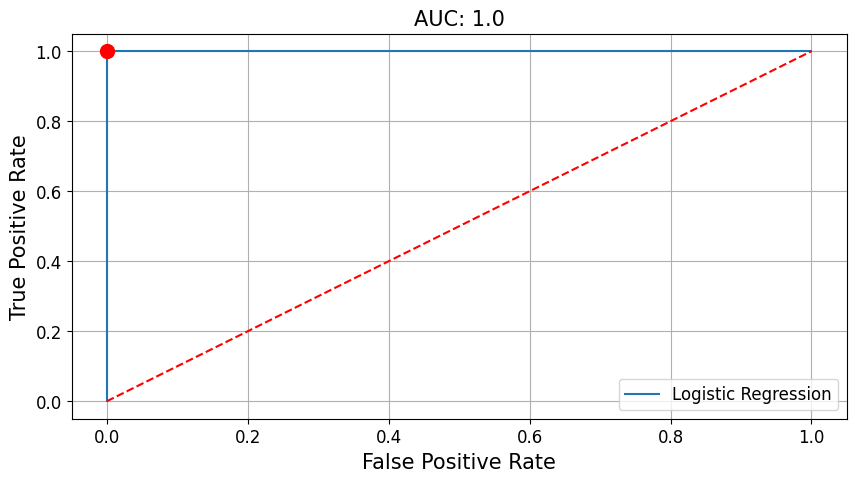

ROC Curve: Test


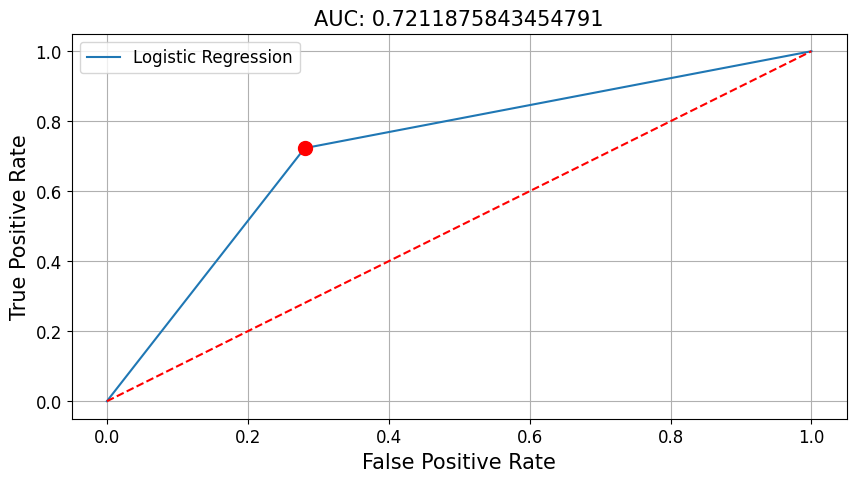

Precision-Recall Curve: Train


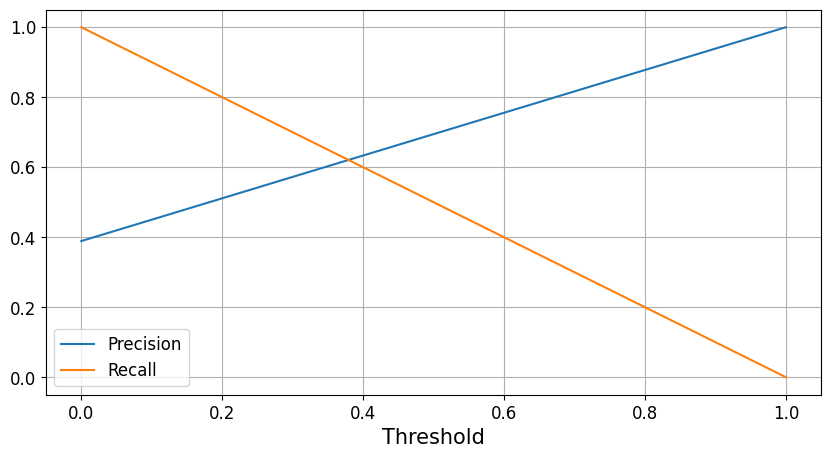

Precision-Recall Curve: Test


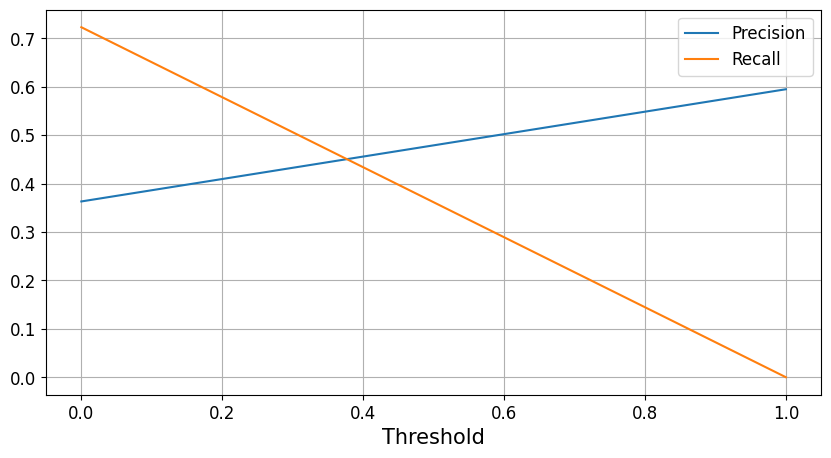

,Accuracy,AUC
Train,1.00,1.00
Test,0.72,0.72


In [15]:
# Decision Tree
model_dt = DecisionTreeClassifier(criterion='entropy', random_state=123)
model_dt.fit(X_train_fes, Y_train)
print('변수 중요도: ')
display(pd.DataFrame(model_dt.feature_importances_,
                     index=model_dt.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_dt.predict(X_train_fes)
Y_tepred = model_dt.predict(X_test_fes)
P_trpred = model_dt.predict_proba(X_train_fes)
P_tepred = model_dt.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_dt = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_dt

### Random Forest

변수 중요도: 


,Importance
PassengerId,0.18
Pclass,0.06
Sex,0.11
Age,0.08
SibSp,0.05
Parch,0.03
Ticket,0.05
Fare,0.16
Cabin,0.06
Name_Mr,0.15


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       435
     class 1       1.00      1.00      1.00       277

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.87      0.86      0.86       114
     class 1       0.76      0.77      0.76        65

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


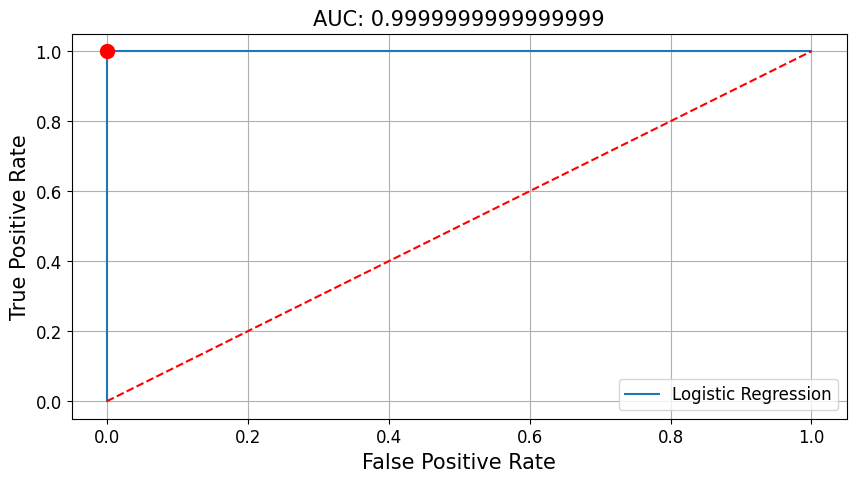

ROC Curve: Test


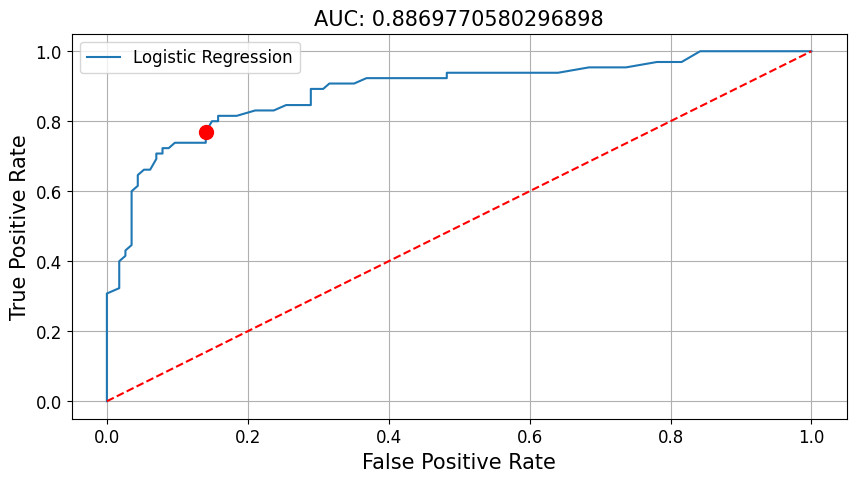

Precision-Recall Curve: Train


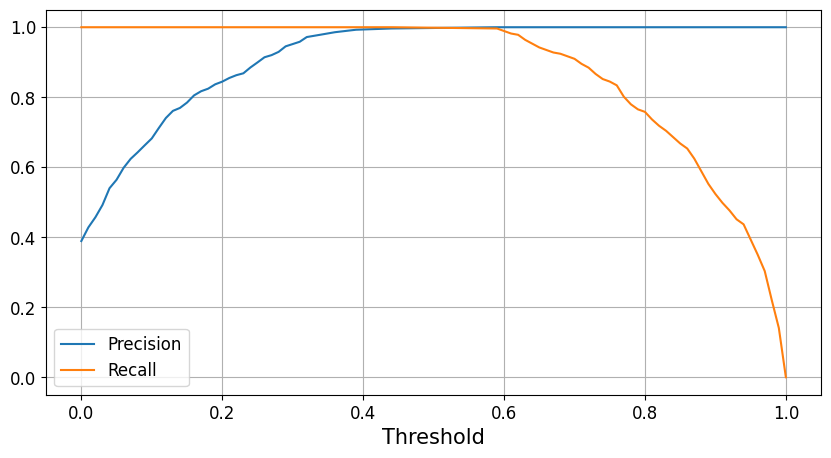

Precision-Recall Curve: Test


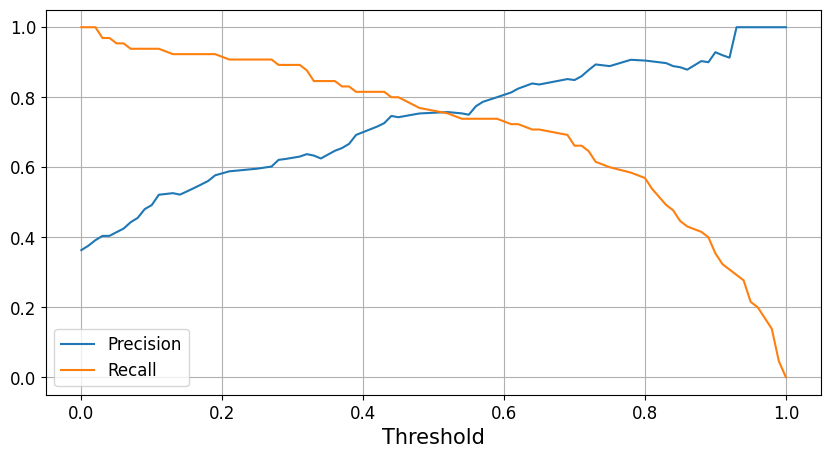

,Accuracy,AUC
Train,1.00,1.00
Test,0.83,0.81


In [16]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=123)
model_rf.fit(X_train_fes, Y_train)
print("변수 중요도: ")
display(pd.DataFrame(model_rf.feature_importances_, 
                     index=model_rf.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_rf.predict(X_train_fes)
Y_tepred = model_rf.predict(X_test_fes)
P_trpred = model_rf.predict_proba(X_train_fes)
P_tepred = model_rf.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_rf = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_rf

### Random Forest with Hyperparameter Tuning

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/mod

Best Parameters:  {'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 100}
Feature Importances: 


,Importance
PassengerId,0.07
Pclass,0.10
Sex,0.16
Age,0.04
SibSp,0.05
Parch,0.02
Ticket,0.02
Fare,0.11
Cabin,0.06
Name_Mr,0.28


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.86      0.92      0.89       435
     class 1       0.85      0.77      0.81       277

    accuracy                           0.86       712
   macro avg       0.86      0.84      0.85       712
weighted avg       0.86      0.86      0.86       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.87      0.87       114
     class 1       0.77      0.78      0.78        65

    accuracy                           0.84       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


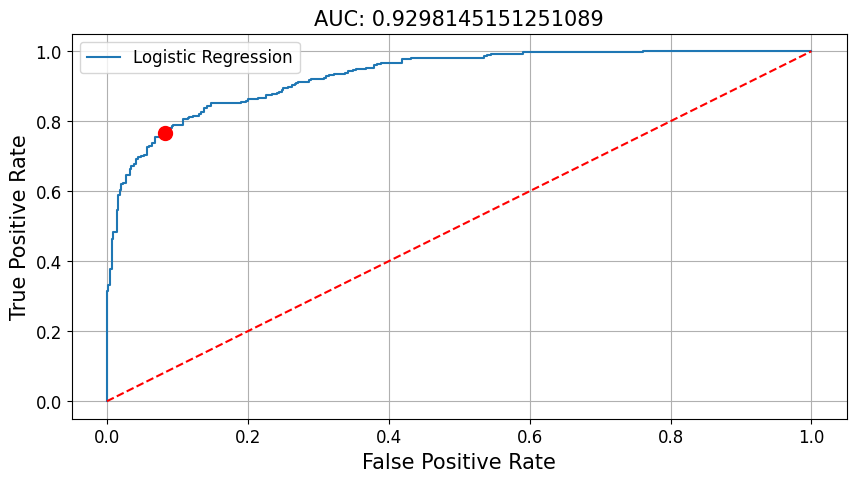

ROC Curve: Test


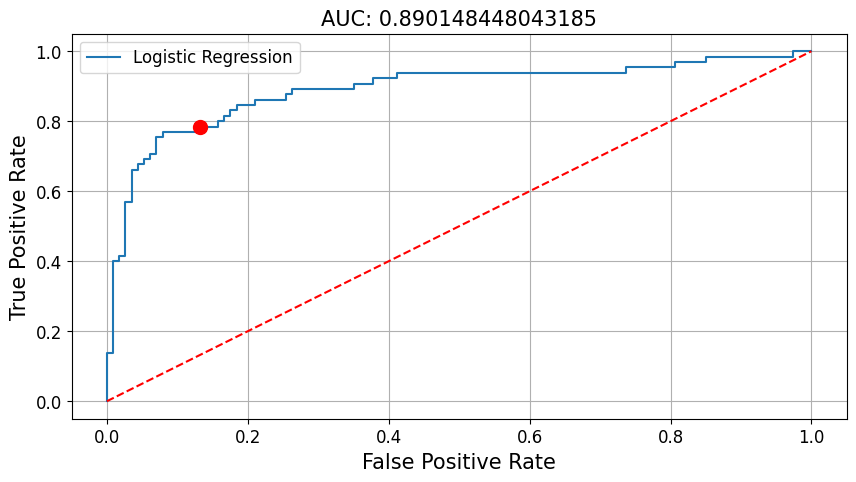

Precision-Recall Curve: Train


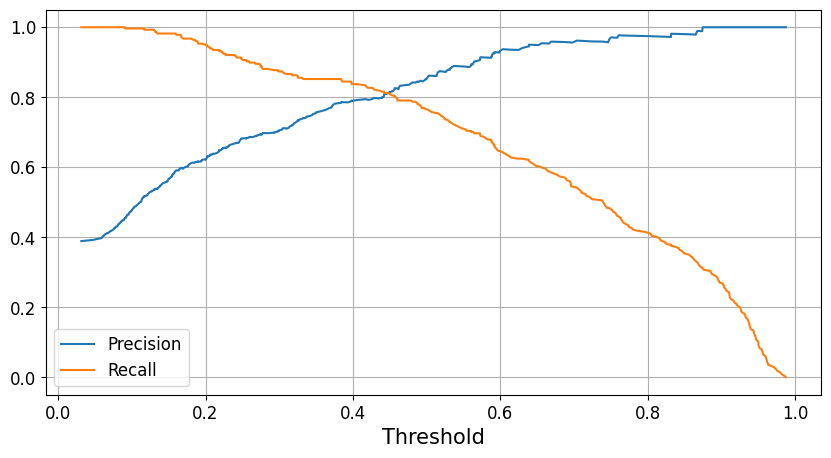

Precision-Recall Curve: Test


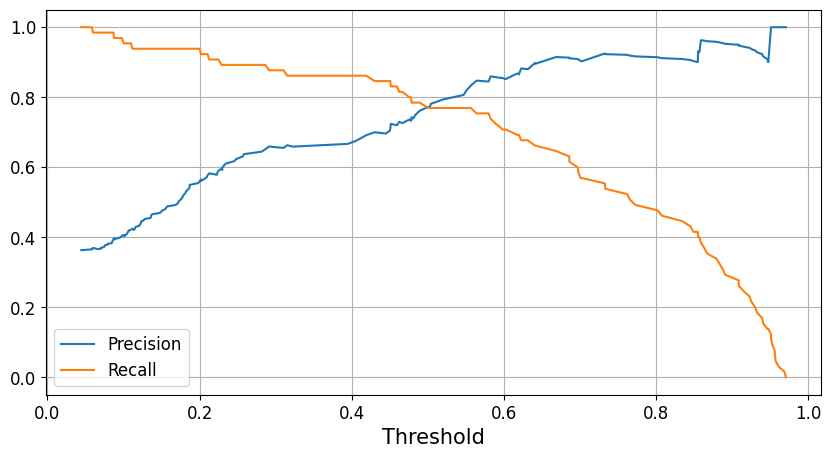

,Accuracy,AUC
Train,0.86,0.84
Test,0.84,0.83


In [18]:
# Random Forest
model_rf = RandomForestClassifier(random_state=123)
params = {'n_estimators': [100],
          'max_depth': [5, 7, 9, 11],
          'min_samples_leaf': [5, 7, 9, 11],
          'min_samples_split': [5, 7, 9, 11]}
model_rf_cv = GridSearchCV(estimator=model_rf, param_grid=params,
                           cv=5,
                           n_jobs=-1)
model_rf_cv.fit(X_train_fes, Y_train)
print('Best Parameters: ', model_rf_cv.best_params_)
model_rf_cv_final = RandomForestClassifier(**model_rf_cv.best_params_)
model_rf_cv_final.fit(X_train_fes, Y_train)
print('Feature Importances: ')
display(pd.DataFrame(model_rf_cv_final.feature_importances_,
                     index=model_rf_cv_final.feature_names_in_, columns=['Importance']))


# 예측
Y_trpred = model_rf_cv_final.predict(X_train_fes)
Y_tepred = model_rf_cv_final.predict(X_test_fes)
P_trpred = model_rf_cv_final.predict_proba(X_train_fes)
P_tepred = model_rf_cv_final.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_rf_cv_final = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_rf_cv_final

## Advanced Algorithm : Boosting

### Gradient Boosting

변수 중요도: 


,Importance
PassengerId,0.07
Pclass,0.10
Sex,0.01
Age,0.04
SibSp,0.02
Parch,0.00
Ticket,0.04
Fare,0.15
Cabin,0.04
Name_Mr,0.46


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.90      0.94      0.92       435
     class 1       0.90      0.83      0.86       277

    accuracy                           0.90       712
   macro avg       0.90      0.89      0.89       712
weighted avg       0.90      0.90      0.90       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.87      0.88      0.87       114
     class 1       0.78      0.77      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


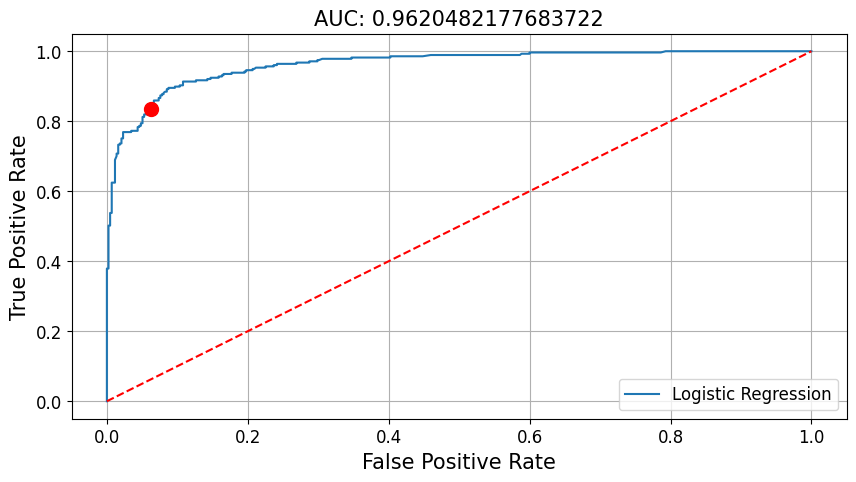

ROC Curve: Test


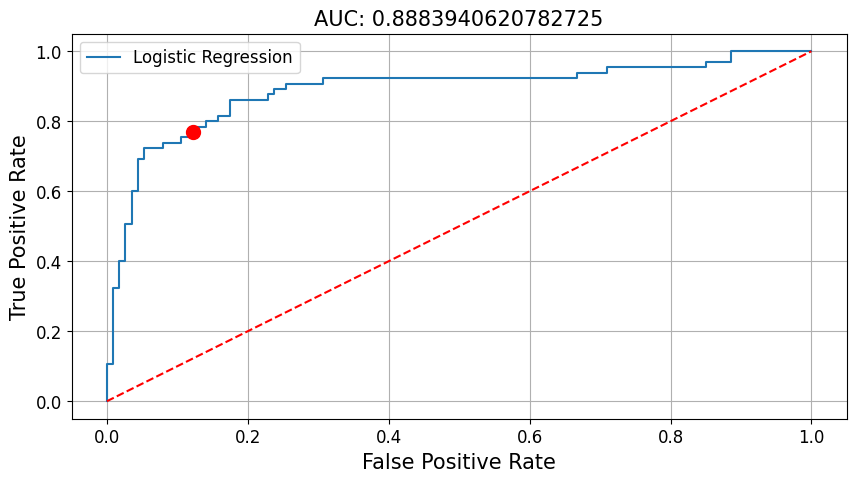

Precision-Recall Curve: Train


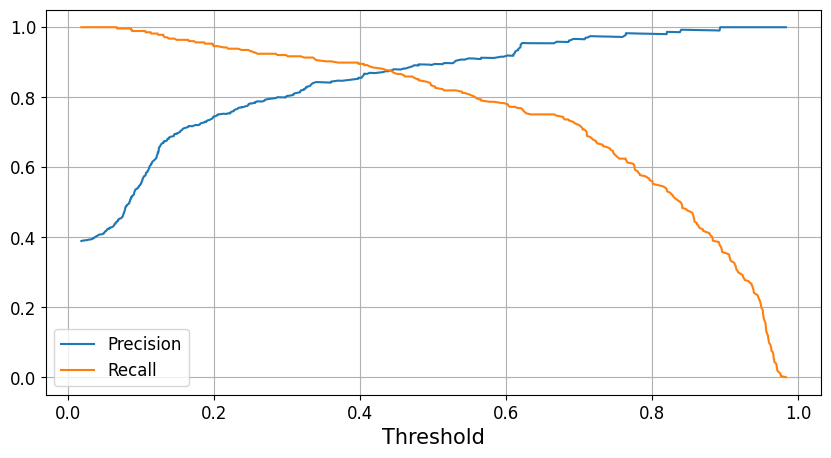

Precision-Recall Curve: Test


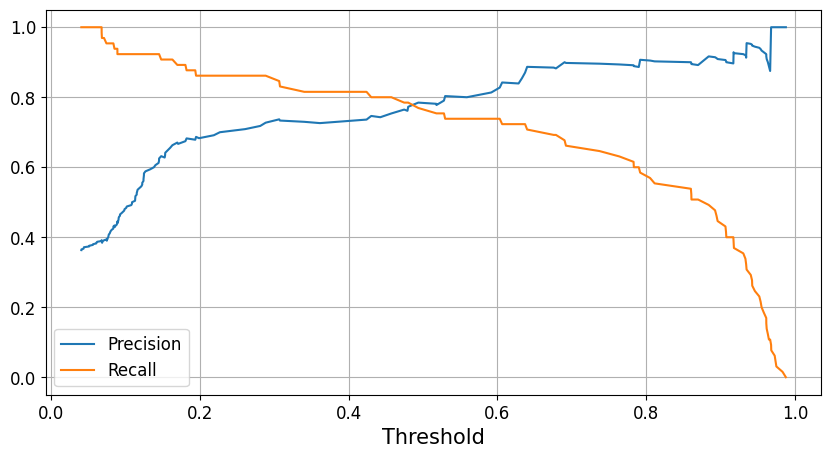

,Accuracy,AUC
Train,0.90,0.89
Test,0.84,0.82


In [19]:
# Gradient Boosting
model_gb = GradientBoostingClassifier(n_estimators=100,
                                      learning_rate=0.1,
                                      max_depth=3, random_state=123)
model_gb.fit(X_train_fes, Y_train)
print("변수 중요도: ")
display(pd.DataFrame(model_gb.feature_importances_, 
                     index=model_gb.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_gb.predict(X_train_fes)
Y_tepred = model_gb.predict(X_test_fes)
P_trpred = model_gb.predict_proba(X_train_fes)
P_tepred = model_gb.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_gb = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_gb

### GBM with Hyperparameter Tuning

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array w

최적 하이퍼 파라미터:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 100}
변수 중요도: 


,Importance
PassengerId,0.17
Pclass,0.09
Sex,0.01
Age,0.05
SibSp,0.02
Parch,0.00
Ticket,0.04
Fare,0.16
Cabin,0.03
Name_Mr,0.36


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.98       435
     class 1       0.98      0.94      0.96       277

    accuracy                           0.97       712
   macro avg       0.97      0.96      0.97       712
weighted avg       0.97      0.97      0.97       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.87      0.87       114
     class 1       0.77      0.78      0.78        65

    accuracy                           0.84       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


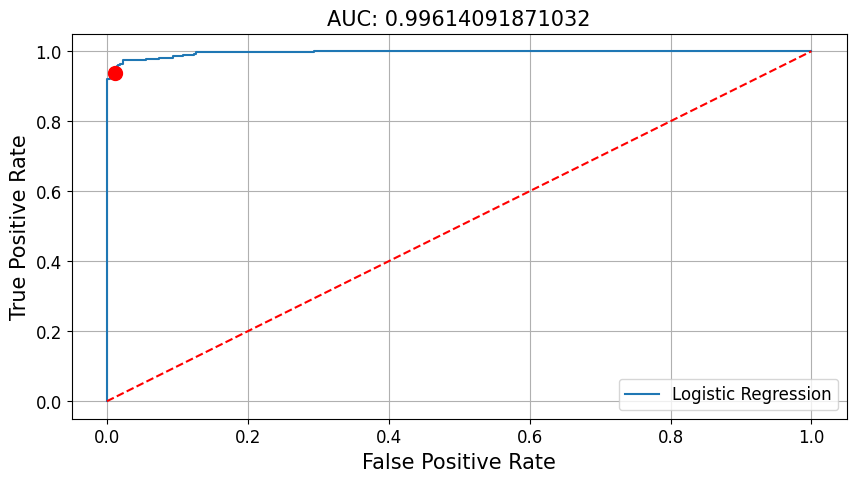

ROC Curve: Test


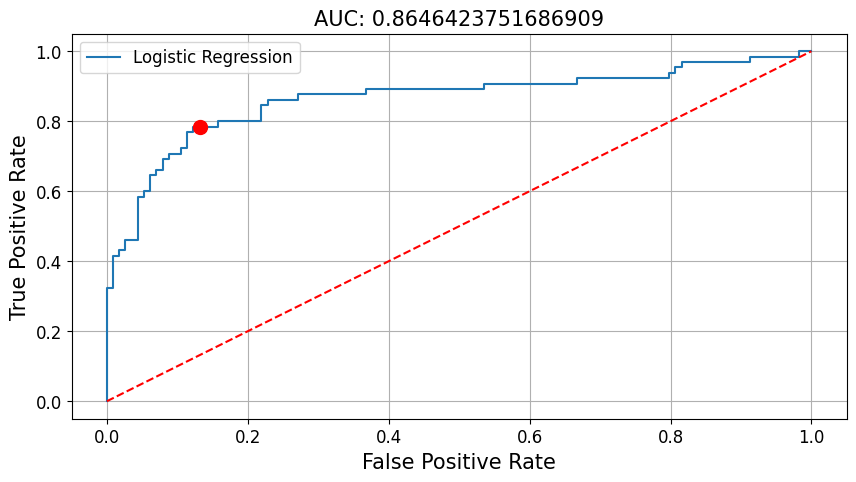

Precision-Recall Curve: Train


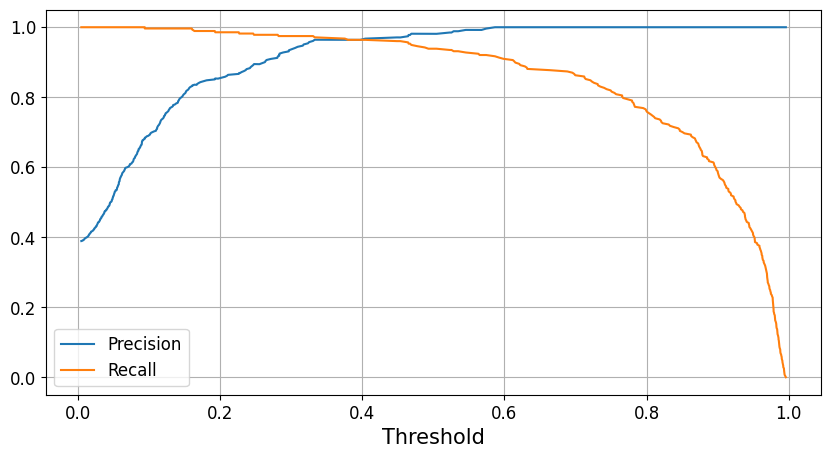

Precision-Recall Curve: Test


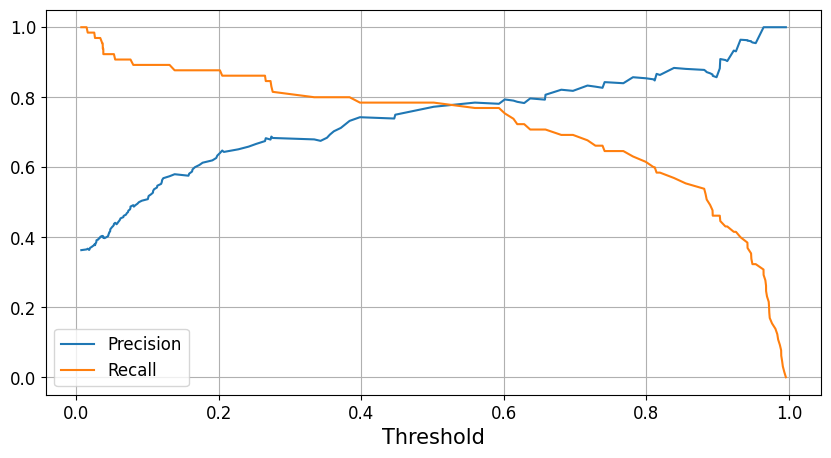

,Accuracy,AUC
Train,0.97,0.96
Test,0.84,0.83


In [20]:
# Gradient Boosting
model_gb = GradientBoostingClassifier()
params = {'n_estimators': [100],   
          'max_depth': [5, 7, 9, 11],    
          'min_samples_leaf': [5, 7, 9, 115],   
          'min_samples_split': [5, 7, 9, 11],  
          'learning_rate': [0.05, 0.1, 0.2]}   
model_gb_cv = GridSearchCV(estimator=model_gb, param_grid=params, 
                           cv=5,   
                           n_jobs=-1)   
model_gb_cv.fit(X_train_fes, Y_train)
print("최적 하이퍼 파라미터: ", model_gb_cv.best_params_)

model_gb_cv_final = GradientBoostingClassifier(**model_gb_cv.best_params_)
model_gb_cv_final.fit(X_train_fes, Y_train)
print("변수 중요도: ")
display(pd.DataFrame(model_gb_cv_final.feature_importances_, 
                     index=model_gb_cv_final.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_gb_cv_final.predict(X_train_fes)
Y_tepred = model_gb_cv_final.predict(X_test_fes)
P_trpred = model_gb_cv_final.predict_proba(X_train_fes)
P_tepred = model_gb_cv_final.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_gb_cv_final = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_gb_cv_final

### XGBoost

변수 중요도(분류기준): 


,Importance
PassengerId,0.02
Pclass,0.10
Sex,0.03
Age,0.02
SibSp,0.04
Parch,0.01
Ticket,0.02
Fare,0.03
Cabin,0.05
Name_Mr,0.49


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.89      0.93      0.91       435
     class 1       0.88      0.81      0.84       277

    accuracy                           0.88       712
   macro avg       0.88      0.87      0.87       712
weighted avg       0.88      0.88      0.88       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.86      0.87       114
     class 1       0.76      0.78      0.77        65

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


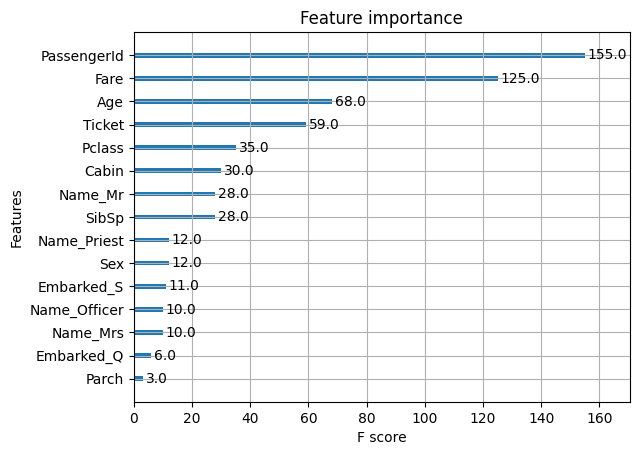

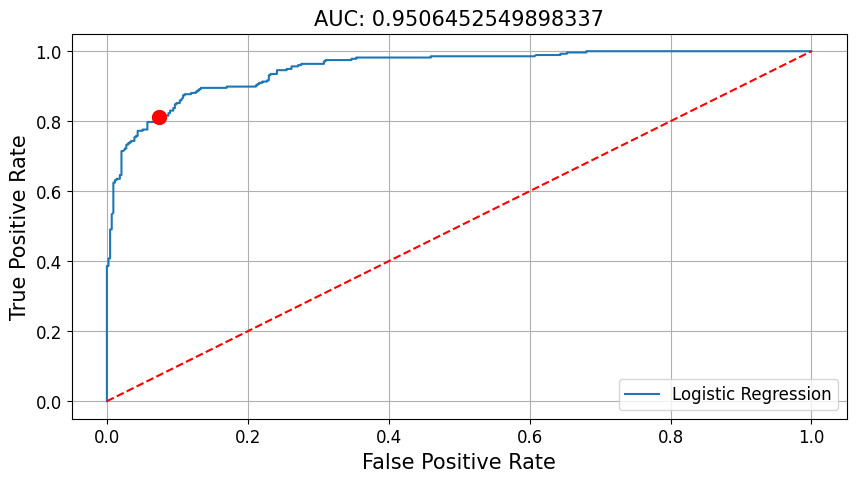

ROC Curve: Test


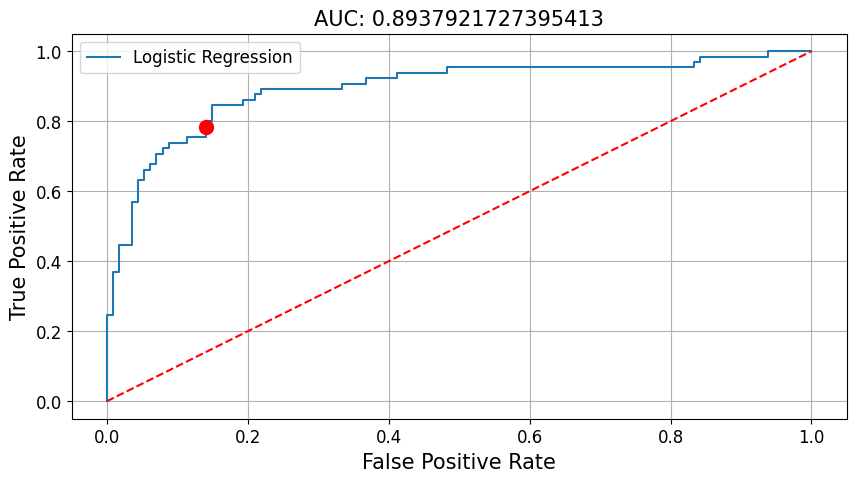

Precision-Recall Curve: Train


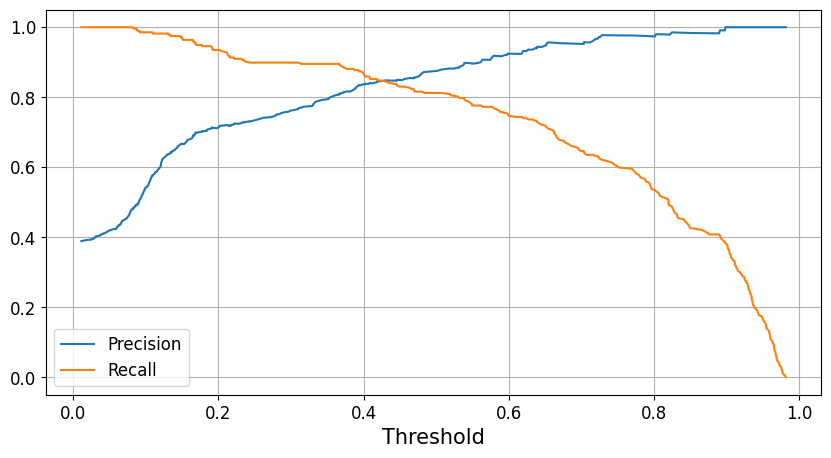

Precision-Recall Curve: Test


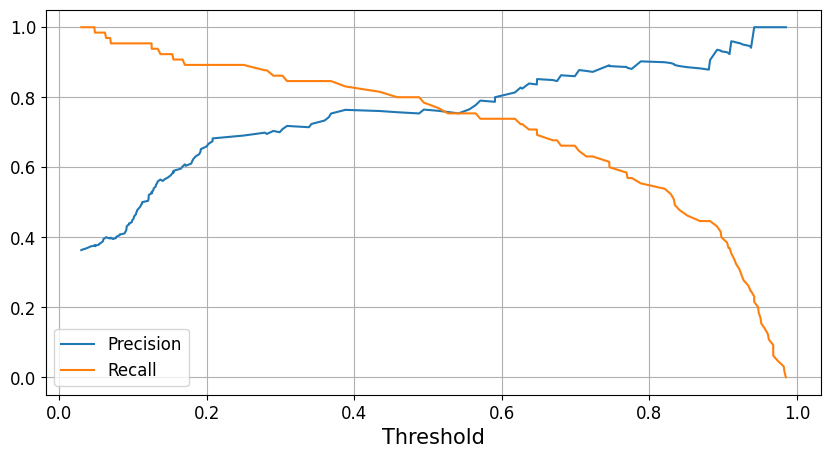

,Accuracy,AUC
Train,0.88,0.87
Test,0.83,0.82


In [21]:
# XGBoost
model_xgb = XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss')
model_xgb.fit(X_train_fes, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_xgb.feature_importances_, 
                     index=model_xgb.feature_names_in_, columns=['Importance']))
print("변수 중요도(성능기준): ")
plot_importance_xgb(model_xgb)

# 예측
Y_trpred = model_xgb.predict(X_train_fes)
Y_tepred = model_xgb.predict(X_test_fes)
P_trpred = model_xgb.predict_proba(X_train_fes)
P_tepred = model_xgb.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_xgb = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_xgb

### XGBoost with Hyperparameter Tuning

최적 하이퍼 파라미터:  {'eval_metric': 'mlogloss', 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 100}
변수 중요도(분류기준): 


,Importance
PassengerId,0.02
Pclass,0.14
Sex,0.31
Age,0.02
SibSp,0.01
Parch,0.02
Ticket,0.01
Fare,0.02
Cabin,0.04
Name_Mr,0.36


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.86      0.92      0.89       435
     class 1       0.87      0.77      0.82       277

    accuracy                           0.87       712
   macro avg       0.87      0.85      0.86       712
weighted avg       0.87      0.87      0.86       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.87      0.87      0.87       114
     class 1       0.77      0.77      0.77        65

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


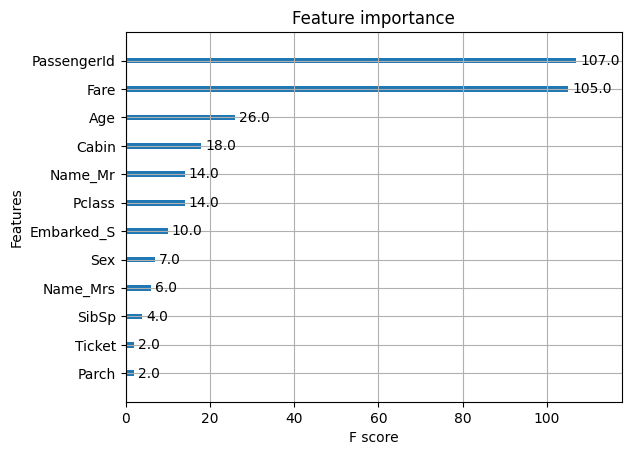

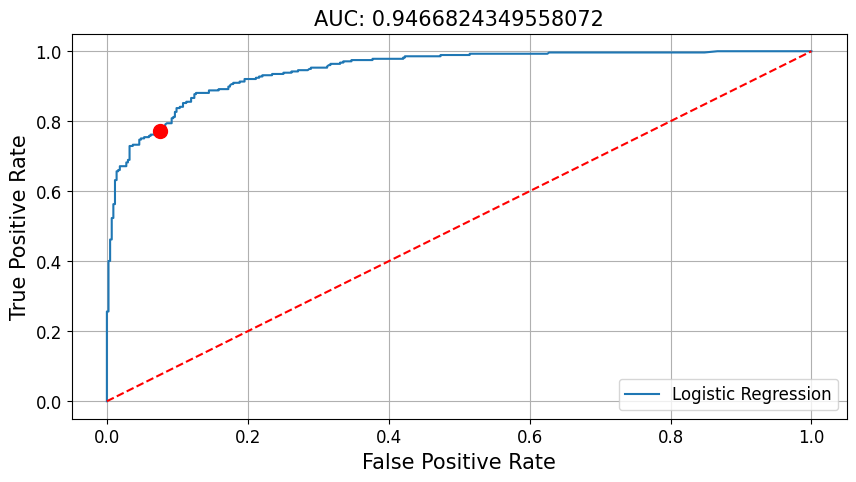

ROC Curve: Test


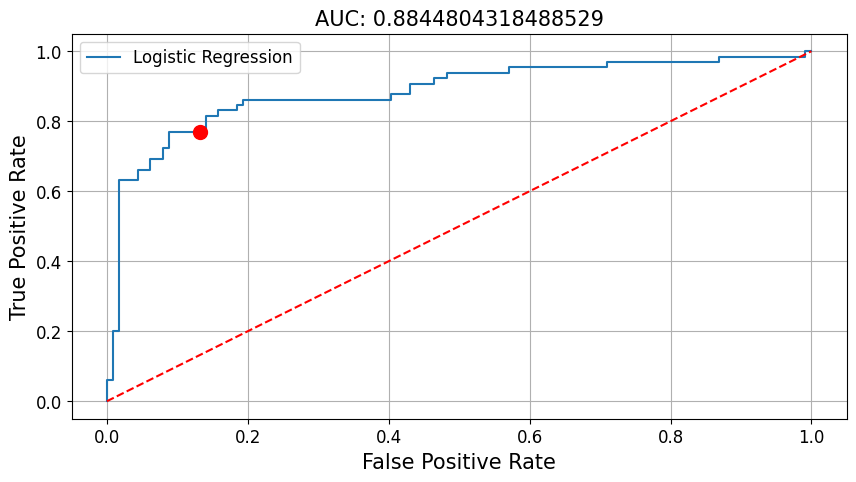

Precision-Recall Curve: Train


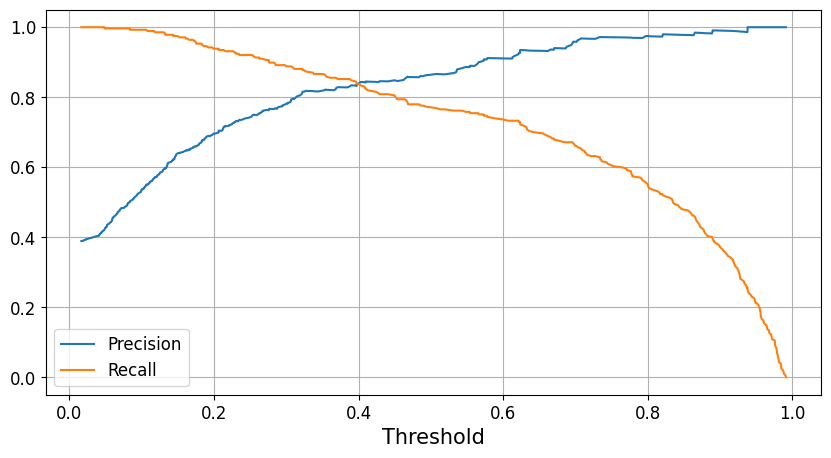

Precision-Recall Curve: Test


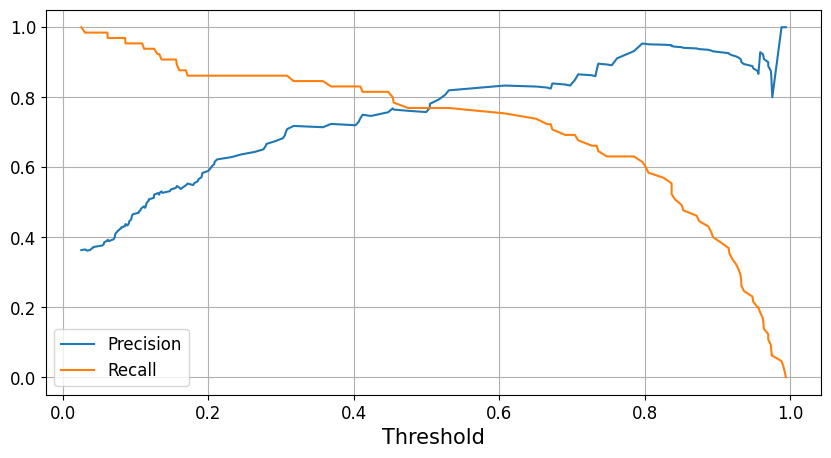

,Accuracy,AUC
Train,0.87,0.85
Test,0.83,0.82


In [22]:
# XGBoost
model_xgb = XGBClassifier()
params = {'n_estimators': [100],    
          'max_depth': [5, 7, 9, 11],    
          'gamma': [0.1, 0.3, 0.5, 0.7, 0.9],   
          'min_child_weight': [5, 7, 9, 11],    
          'eval_metric': ['mlogloss']}
model_xgb_cv = GridSearchCV(estimator=model_xgb, param_grid=params, 
                            cv=5,  
                            n_jobs=-1)    
model_xgb_cv.fit(X_train_fes, Y_train)
print("최적 하이퍼 파라미터: ", model_xgb_cv.best_params_)

model_xgb_cv_final = XGBClassifier(**model_xgb_cv.best_params_)
model_xgb_cv_final.fit(X_train_fes, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_xgb_cv_final.feature_importances_, 
                     index=model_xgb_cv_final.feature_names_in_, columns=['Importance']))
print("변수 중요도(성능기준): ")
plot_importance_xgb(model_xgb_cv_final)

# 예측
Y_trpred = model_xgb_cv_final.predict(X_train_fes)
Y_tepred = model_xgb_cv_final.predict(X_test_fes)
P_trpred = model_xgb_cv_final.predict_proba(X_train_fes)
P_tepred = model_xgb_cv_final.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_xgb_cv_final = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_xgb_cv_final

### Light BGM

In [23]:
# # LightGBM
# model_lgbm = LGBMClassifier(n_estimators=100,
#                             learning_rate=0.1,
#                             max_depth=3, random_state=123)
# model_lgbm.fit(X_train_fes, Y_train)
# print("변수 중요도(분류기준): ")
# display(pd.DataFrame(model_lgbm.feature_importances_, 
#                      index=model_lgbm.feature_name_, columns=['Importance']))
# print("변수 중요도(성능기준): ")
# plot_importance_lgbm(model_lgbm)

# # 예측
# Y_trpred = model_lgbm.predict(X_train_fes)
# Y_tepred = model_lgbm.predict(X_test_fes)
# P_trpred = model_lgbm.predict_proba(X_train_fes)
# P_tepred = model_lgbm.predict_proba(X_test_fes)

# # 평가/검증
# ## Confusion Matrix
# print('Confusion Matrix: Train')
# evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
# print('Confusion Matrix: Test')
# evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

# ## Classification Metrics
# print('Classification Metrics: Train')
# evaluation_class_ClassificationReport(Y_train, Y_trpred)
# print('Classification Metrics: Test')
# evaluation_class_ClassificationReport(Y_test, Y_tepred)

# ## ROC Curve + AUC
# print('ROC Curve: Train')
# evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
# print('ROC Curve: Test')
# evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

# ## Precision-Recall Curve
# print('Precision-Recall Curve: Train')
# evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
# print('Precision-Recall Curve: Test')
# evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

# ## 성능검증
# Score_lgbm = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
# Score_lgbm

### LightGBM with Hyperparameter Tuning

In [24]:
# # LightGBM
# model_lgbm = LGBMClassifier()
# params = {'n_estimators': [100],    
#           'max_depth': [5, 7, 9, 11],   
#           'gamma': [0.1, 0.3, 0.5, 0.7, 0.9],   
#           'min_child_weight': [5, 7, 9, 11]}    
# model_lgbm_cv = GridSearchCV(estimator=model_lgbm, param_grid=params, 
#                              cv=5,    
#                              n_jobs=-1)     
# model_lgbm_cv.fit(X_train_fes, Y_train)
# print("최적 하이퍼 파라미터: ", model_lgbm_cv.best_params_)

# model_lgbm_cv_final = LGBMClassifier(**model_lgbm_cv.best_params_)
# model_lgbm_cv_final.fit(X_train_fes, Y_train)
# print("변수 중요도(분류기준): ")
# display(pd.DataFrame(model_lgbm_cv_final.feature_importances_, 
#                      index=model_lgbm_cv_final.feature_name_, columns=['Importance']))
# print("변수 중요도(성능기준): ")
# plot_importance_lgbm(model_lgbm_cv_final)

# # 예측
# Y_trpred = model_lgbm_cv_final.predict(X_train_fes)
# Y_tepred = model_lgbm_cv_final.predict(X_test_fes)
# P_trpred = model_lgbm_cv_final.predict_proba(X_train_fes)
# P_tepred = model_lgbm_cv_final.predict_proba(X_test_fes)

# # 평가/검증
# ## Confusion Matrix
# print('Confusion Matrix: Train')
# evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
# print('Confusion Matrix: Test')
# evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

# ## Classification Metrics
# print('Classification Metrics: Train')
# evaluation_class_ClassificationReport(Y_train, Y_trpred)
# print('Classification Metrics: Test')
# evaluation_class_ClassificationReport(Y_test, Y_tepred)

# ## ROC Curve + AUC
# print('ROC Curve: Train')
# evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
# print('ROC Curve: Test')
# evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

# ## Precision-Recall Curve
# print('Precision-Recall Curve: Train')
# evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
# print('Precision-Recall Curve: Test')
# evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

# ## 성능검증
# Score_lgbm_cv_final = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
# Score_lgbm_cv_final


### CatBoost

변수 중요도(분류기준): 


,Importance
PassengerId,2.71
Pclass,13.95
Sex,15.01
Age,5.69
SibSp,4.89
Parch,0.37
Ticket,2.49
Fare,5.61
Cabin,6.00
Name_Mr,38.48


변수 중요도(성능기준): 
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.86      0.90      0.88       435
     class 1       0.83      0.77      0.80       277

    accuracy                           0.85       712
   macro avg       0.84      0.83      0.84       712
weighted avg       0.85      0.85      0.85       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.88      0.88       114
     class 1       0.78      0.78      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


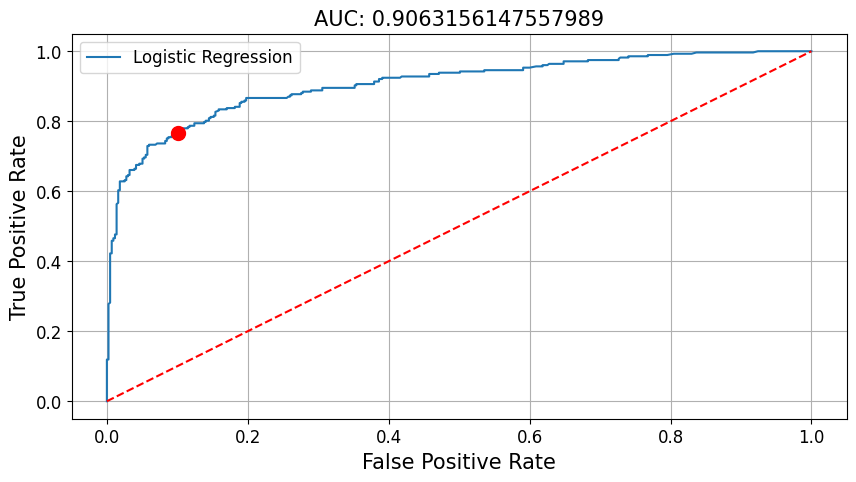

ROC Curve: Test


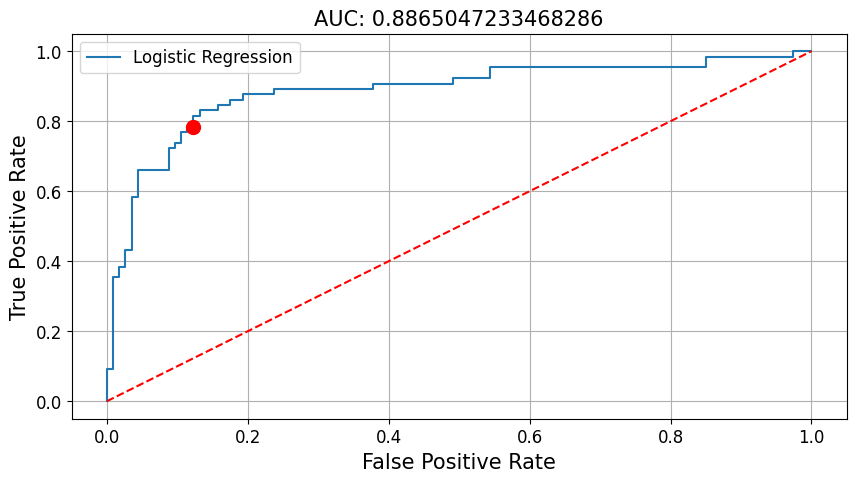

Precision-Recall Curve: Train


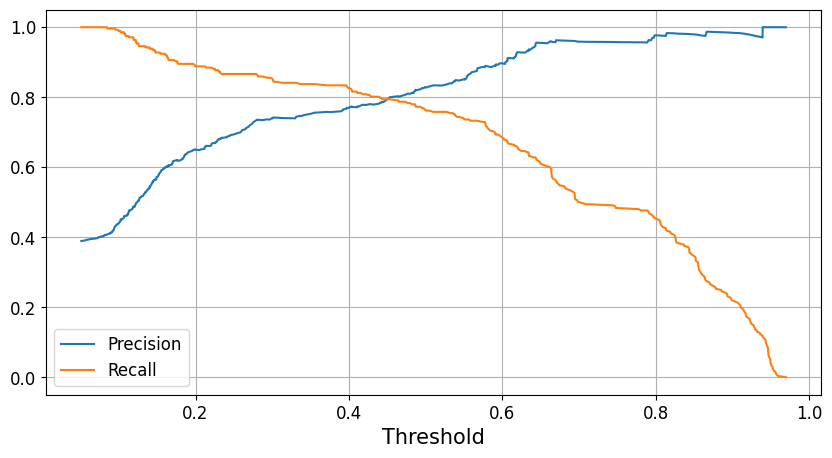

Precision-Recall Curve: Test


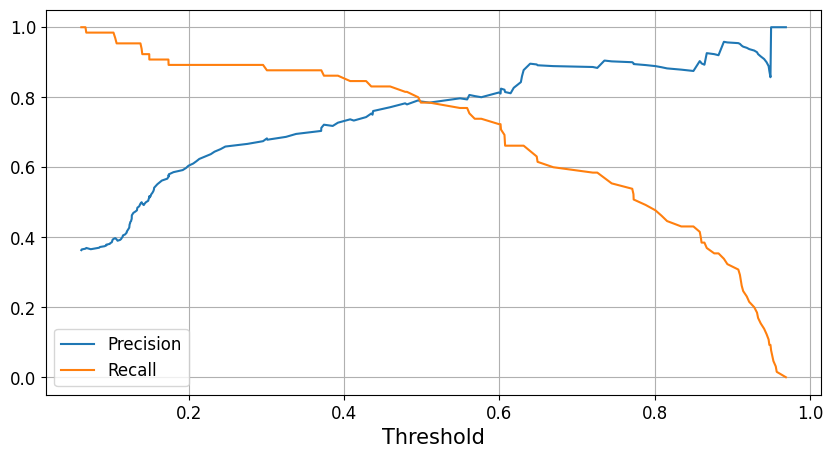

,Accuracy,AUC
Train,0.85,0.83
Test,0.84,0.83


In [25]:
# CatBoost
model_cb = CatBoostClassifier(n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3, random_state=123,
                              verbose=0)
model_cb.fit(X_train_fes, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_cb.feature_importances_, 
                     index=model_cb.feature_names_, columns=['Importance']))
print("변수 중요도(성능기준): ")

# 예측
Y_trpred = model_cb.predict(X_train_fes)
Y_tepred = model_cb.predict(X_test_fes)
P_trpred = model_cb.predict_proba(X_train_fes)
P_tepred = model_cb.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_cb = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_cb

### CatBoost with Hyperparameter Tuning

최적 하이퍼 파라미터:  {'max_depth': 7, 'n_estimators': 100}
Learning rate set to 0.073611
0:	learn: 0.6638094	total: 521us	remaining: 51.6ms
1:	learn: 0.6415075	total: 990us	remaining: 48.6ms
2:	learn: 0.6220584	total: 1.42ms	remaining: 45.9ms
3:	learn: 0.6050124	total: 1.93ms	remaining: 46.4ms
4:	learn: 0.5879276	total: 2.41ms	remaining: 45.8ms
5:	learn: 0.5732937	total: 2.83ms	remaining: 44.3ms
6:	learn: 0.5587037	total: 3.2ms	remaining: 42.5ms
7:	learn: 0.5472771	total: 3.56ms	remaining: 41ms
8:	learn: 0.5370884	total: 4ms	remaining: 40.5ms
9:	learn: 0.5254218	total: 4.39ms	remaining: 39.5ms
10:	learn: 0.5157569	total: 4.87ms	remaining: 39.4ms
11:	learn: 0.5054980	total: 5.36ms	remaining: 39.3ms
12:	learn: 0.4960305	total: 5.52ms	remaining: 37ms
13:	learn: 0.4892476	total: 5.92ms	remaining: 36.4ms
14:	learn: 0.4820263	total: 6.4ms	remaining: 36.3ms
15:	learn: 0.4747184	total: 6.86ms	remaining: 36ms
16:	learn: 0.4694385	total: 7.08ms	remaining: 34.6ms
17:	learn: 0.4640877	total: 7.5ms	remain

,Importance
PassengerId,5.38
Pclass,10.65
Sex,19.30
Age,6.52
SibSp,5.36
Parch,1.53
Ticket,3.37
Fare,8.42
Cabin,5.52
Name_Mr,28.19


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.87      0.92      0.90       435
     class 1       0.87      0.79      0.83       277

    accuracy                           0.87       712
   macro avg       0.87      0.86      0.86       712
weighted avg       0.87      0.87      0.87       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.89      0.87      0.88       114
     class 1       0.78      0.82      0.80        65

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

ROC Curve: Train


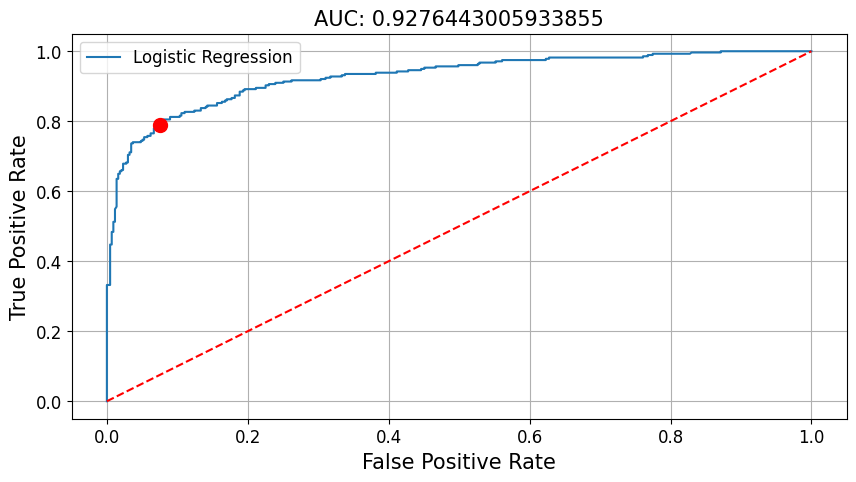

ROC Curve: Test


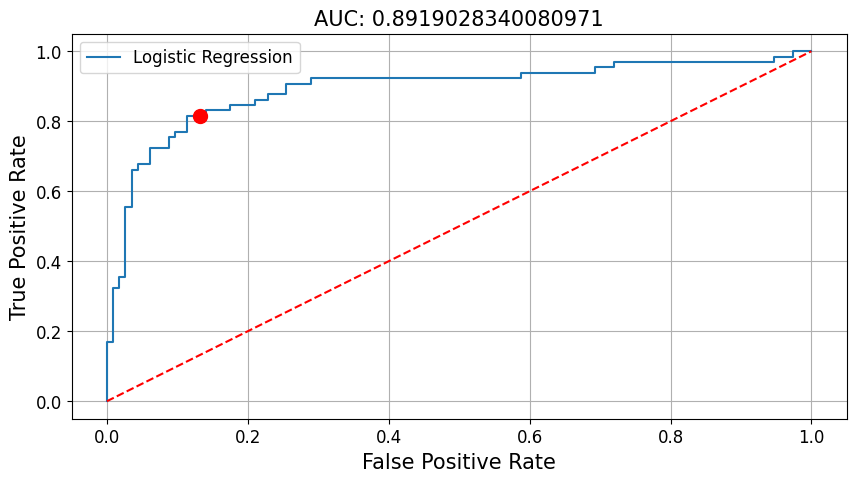

Precision-Recall Curve: Train


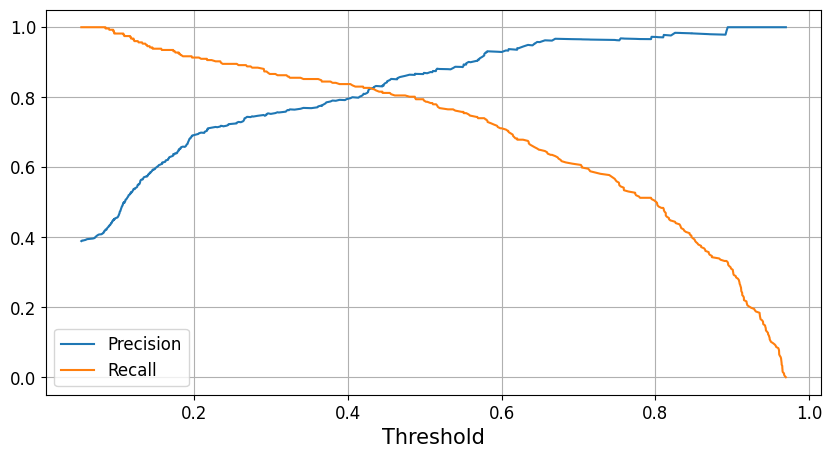

Precision-Recall Curve: Test


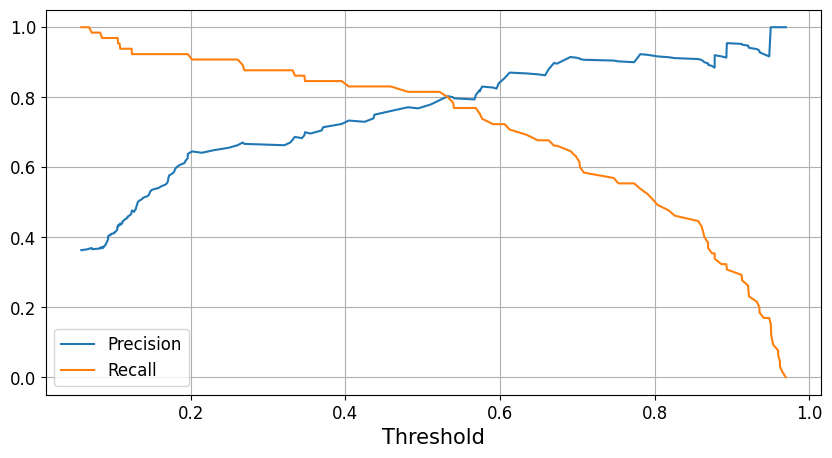

,Accuracy,AUC
Train,0.87,0.86
Test,0.85,0.84


In [26]:
# CatBoost
model_cb = CatBoostClassifier(verbose=0)
params = {'n_estimators': [100],    
          'max_depth': [5, 7, 9, 11]}    
model_cb_cv = GridSearchCV(estimator=model_cb, param_grid=params, 
                           cv=5,    
                           n_jobs=-1)     
model_cb_cv.fit(X_train_fes, Y_train)
print("최적 하이퍼 파라미터: ", model_cb_cv.best_params_)

model_cb_cv_final = CatBoostClassifier(**model_cb_cv.best_params_)
model_cb_cv_final.fit(X_train_fes, Y_train)
print("변수 중요도(분류기준): ")
display(pd.DataFrame(model_cb_cv_final.feature_importances_, 
                     index=model_cb_cv_final.feature_names_, columns=['Importance']))

# 예측
Y_trpred = model_cb_cv_final.predict(X_train_fes)
Y_tepred = model_cb_cv_final.predict(X_test_fes)
P_trpred = model_cb_cv_final.predict_proba(X_train_fes)
P_tepred = model_cb_cv_final.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_cb_cv_final = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_cb_cv_final

## Advanced Algorithm: Stacking

### Stacking

Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       435
     class 1       1.00      1.00      1.00       277

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.86      0.87       114
     class 1       0.76      0.78      0.77        65

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


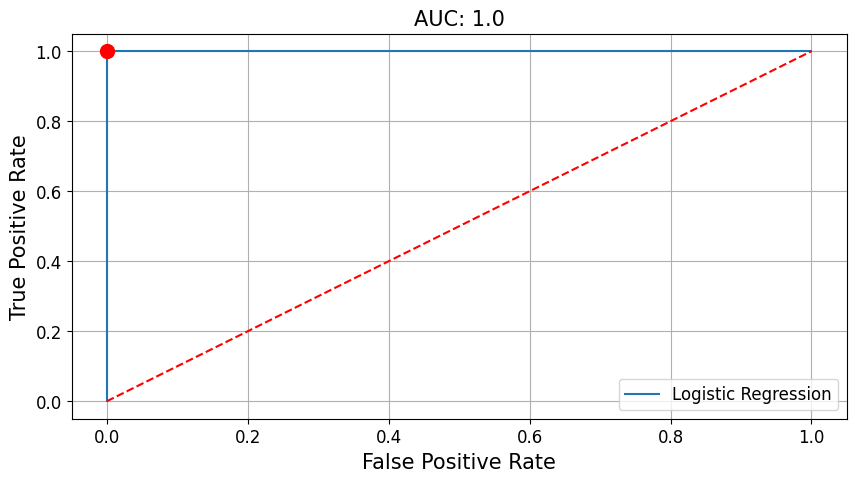

ROC Curve: Test


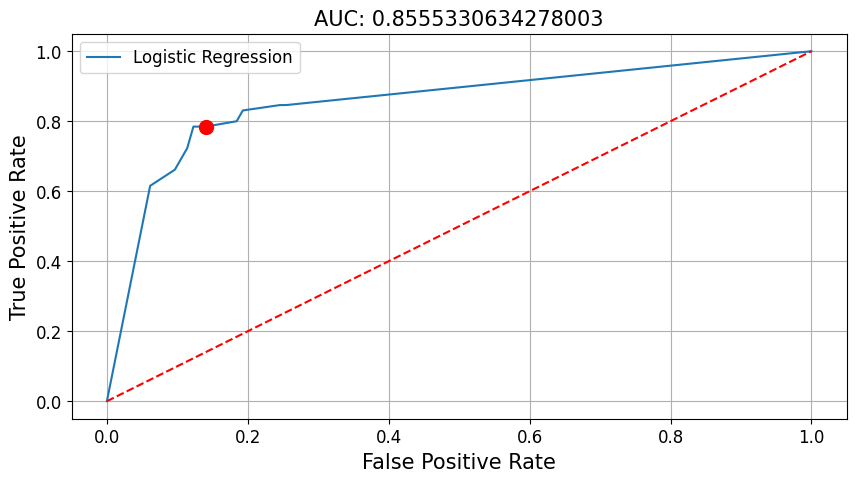

Precision-Recall Curve: Train


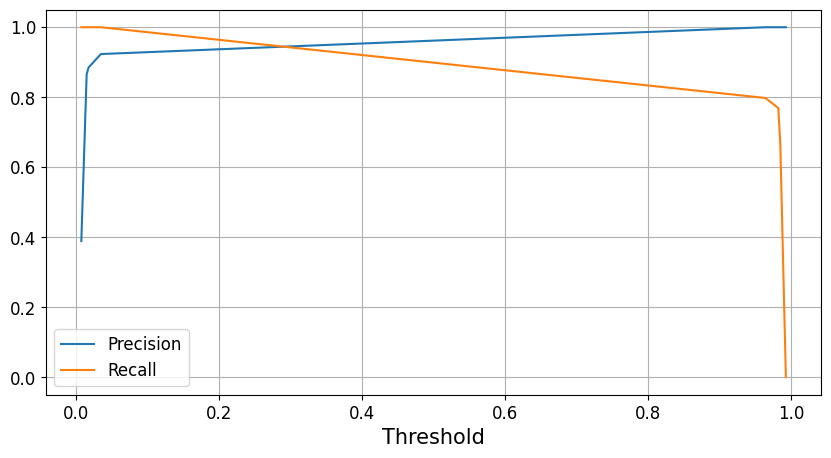

Precision-Recall Curve: Test


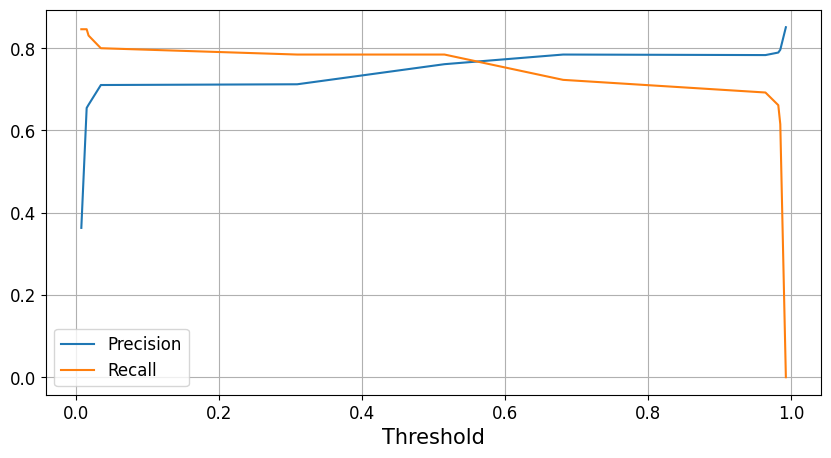

,Accuracy,AUC
Train,1.00,1.00
Test,0.83,0.82


In [27]:
# Stacking
## Weak Learners
model_knn = KNeighborsClassifier()
model_svm = SVC()
model_rf = RandomForestClassifier()
model_xgb = XGBClassifier(eval_metric='mlogloss')

model_logitreg = LogisticRegression()
clf = [model_knn, model_svm, model_rf, model_xgb]
model_stack = StackingClassifier(classifiers=clf, 
                                 meta_classifier=model_logitreg)
model_stack.fit(X_train_fes, Y_train)

# 예측
Y_trpred = model_stack.predict(X_train_fes)
Y_tepred = model_stack.predict(X_test_fes)
P_trpred = model_stack.predict_proba(X_train_fes)
P_tepred = model_stack.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_stack = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_stack

### Stacking with Hyperparameter Tuning

/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/woojin/miniforge3/envs/tf/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was

Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.92      0.98      0.95       435
     class 1       0.96      0.87      0.91       277

    accuracy                           0.94       712
   macro avg       0.94      0.92      0.93       712
weighted avg       0.94      0.94      0.93       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.89      0.89      0.89       114
     class 1       0.81      0.80      0.81        65

    accuracy                           0.86       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.86      0.86      0.86       179

ROC Curve: Train


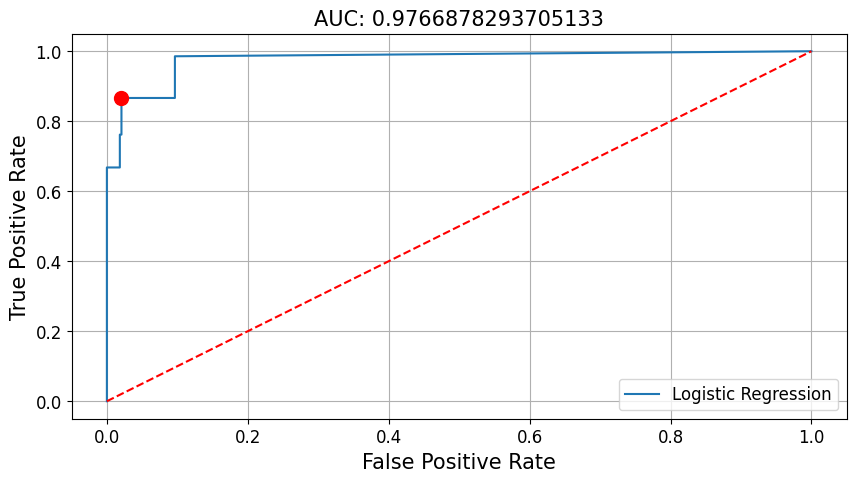

ROC Curve: Test


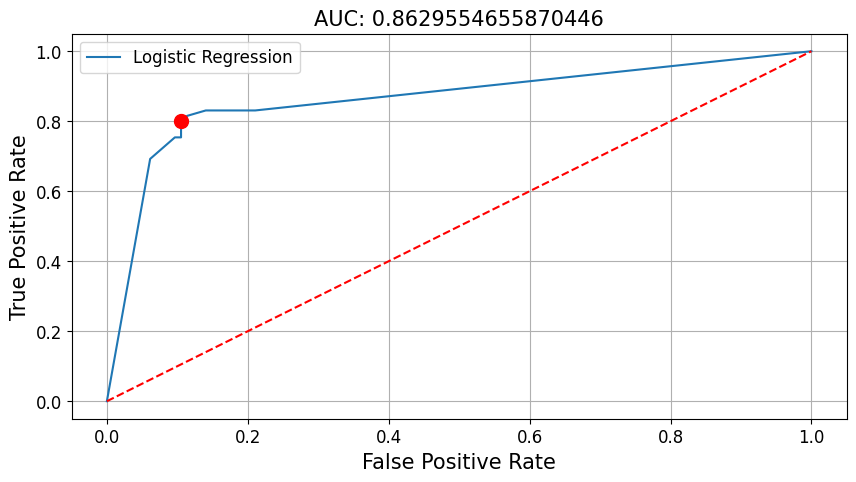

Precision-Recall Curve: Train


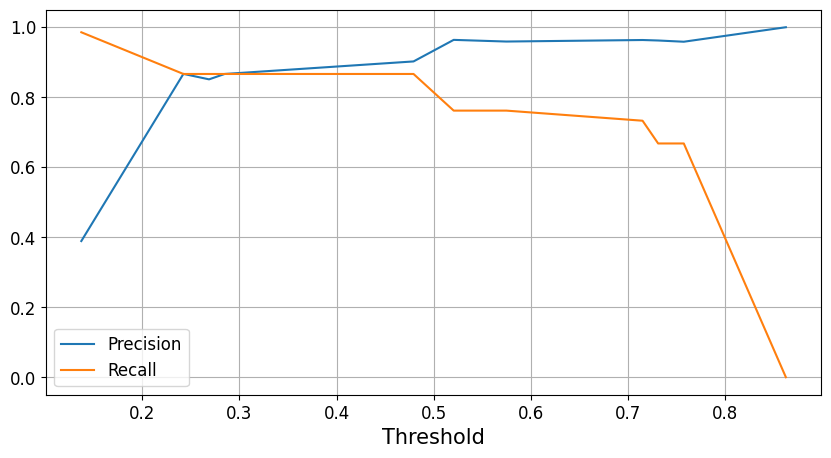

Precision-Recall Curve: Test


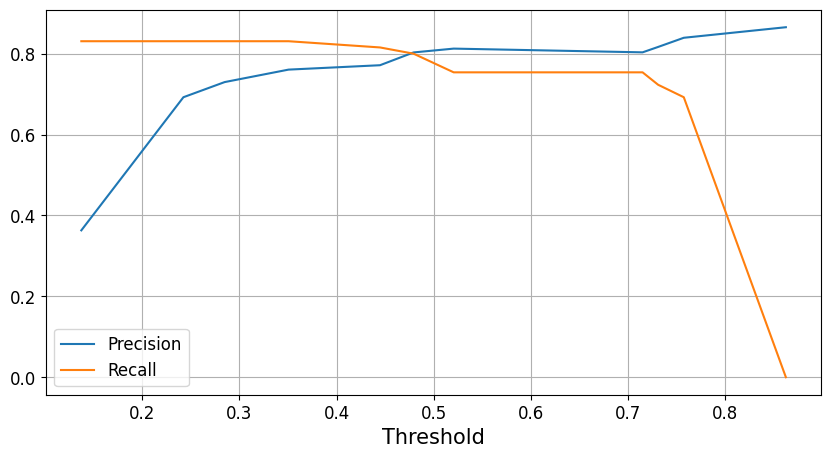

,Accuracy,AUC
Train,0.94,0.92
Test,0.86,0.85


In [28]:
# Stacking
## Weak Learners
model_knn = KNeighborsClassifier()
model_svm = SVC()
model_rf = RandomForestClassifier()
model_xgb = XGBClassifier(eval_metric='mlogloss')

model_logitreg = LogisticRegression()
clf = [model_knn, model_svm, model_rf, model_xgb]
model_stack = StackingCVClassifier(classifiers=clf, meta_classifier=model_logitreg)
params = {'kneighborsclassifier__n_neighbors': [5, 7],
          'svc__kernel': ['rbf'],
          'randomforestclassifier__n_estimators': [100],
          'randomforestclassifier__max_depth': [5, 7, 9],    
          'xgbclassifier__n_estimators': [100],    
          'xgbclassifier__max_depth': [5, 7, 9],
          'xgbclassifier__eval_metric': ['mlogloss']}
model_stack_cv = GridSearchCV(estimator=model_stack, param_grid=params, 
                              cv=5,  
                              n_jobs=-1)    
model_stack_cv.fit(X_train_fes, Y_train)

# 예측
Y_trpred = model_stack_cv.predict(X_train_fes)
Y_tepred = model_stack_cv.predict(X_test_fes)
P_trpred = model_stack_cv.predict_proba(X_train_fes)
P_tepred = model_stack_cv.predict_proba(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

## 성능검증
Score_stack_cv = evaluation_class_AccuracyAUC(Y_train, Y_trpred, Y_test, Y_tepred)
Score_stack_cv

## Comnparison

,Accuracy,AUC
Logistic Regression,0.84,0.83
Ridge,0.82,0.82
Lasso,0.80,0.80
Elastic Net,0.82,0.81
Voting,0.84,0.83
Decision Tree,0.72,0.72
Random Forest,0.83,0.81
RF with CF,0.84,0.83
Gradient Boosting,0.84,0.82
GBM with CV,0.84,0.83


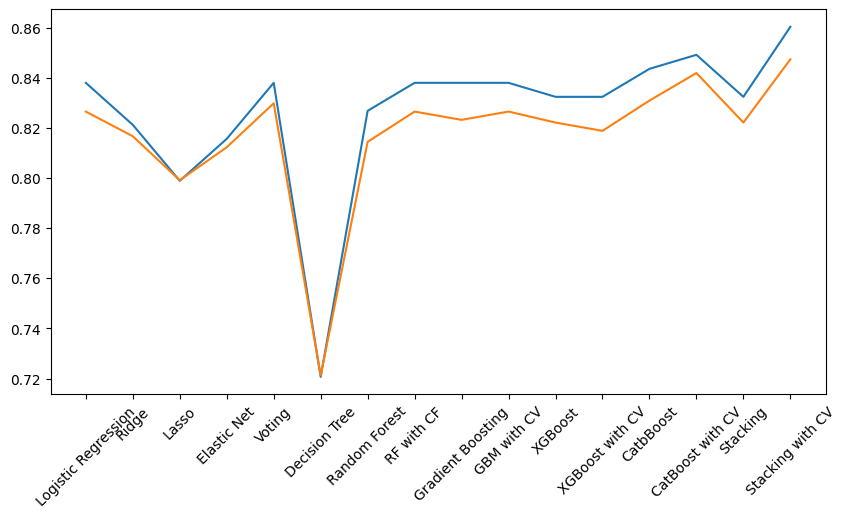

In [29]:
# 결과비교
labels = ['Logistic Regression', 'Ridge', 'Lasso', 'Elastic Net',
          'Voting', 'Decision Tree', 'Random Forest', 'RF with CF', 
          'Gradient Boosting', 'GBM with CV', 'XGBoost', 'XGBoost with CV', 
        #   'LightGBM', 'LightGBM with CV', 
          'CatbBoost', 'CatBoost with CV',
          'Stacking', 'Stacking with CV']
models = [Score_logitreg, Score_ridge, Score_lasso, Score_en,
          Score_voting, Score_dt,
          Score_rf, Score_rf_cv_final, Score_gb, Score_gb_cv_final,
          Score_xgb, Score_xgb_cv_final, 
        #   Score_lgbm, Score_lgbm_cv_final, 
          Score_cb, Score_cb_cv_final, Score_stack, Score_stack_cv]
result_classification = pd.DataFrame()
for result in models:
    result_classification = pd.concat([result_classification, result.iloc[1:,:]], axis=0)
result_classification.index = labels
display(result_classification)

# 시각화
plt.figure(figsize=(10,5))
plt.plot(result_classification)
plt.xticks(rotation=45)
plt.show()